![logo](../img/LogoLine_horizon_C3S.png)

# C3S Aerosol

This second notebook extends the practical introduction of the first notebook to the 
[C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
dataset.
We create a full Climate Data Record by combining subsequent data record pieces of similar sensors. We start by downloading the data from the Climate Data Store (CDS) and then demonstrate three use cases for monthly mean multi-sensor data records: calculate and plot a regional data record, calculate and plot a regional multi-annual mean ("climatology") and plot a regional anomaly time series.

The notebook has six main sections with the following outline:


## Table of Contents

* Introduction
* Download Data Using CDS API
* Use case 1: Create and plot regional data record
* Use case 2: Calculate and plot regional climatology
* Use case 3: Plot regional Anomaly time series
* References

## How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

|Binder|Kaggle|Colab|NBViewer|
|:-:|:-:|:-:|:-:|
|[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/C3S_climate-data-store.ipynb)|[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store.ipynb)|[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store)|[![NBViewer](https://raw.githubusercontent.com/ecmwf-projects/copernicus-training/master/img/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store.ipynb)|
|(Binder may take some time to load, so please be patient!)|(will need to login/register, and switch on the internet via *settings*)|(will need to run the command `!pip install cartopy` before importing the libraries)|(this will not run the notebook, only render it)|

If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need. You will also need to install  the CDS API (`pip install cdsapi`) for downloading data in batch mode from the CDS.

## <a id='intro'></a>Introduction

This second notebook focuses on vombining subsequent parts of a long term record from a sequence of similar sensors, so that relevant Cliamte Data Records can be provided. While exceptionally large expisodic extreme events may be seen in short records of a few years only, slower long-term changes of atmospheric aerosols can only be seen in records of one or more decades.

### Import libraries

We will be working with data in NetCDF format. To best handle this data we will use the netCDF4 python library. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it: <br>


In [1]:
#!pip install cdsapi

In [2]:
%matplotlib inline

# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import numpy.ma as ma
import netCDF4 as nc

# Library to work with zip-archives, OS-functions and pattern expansion
import zipfile
import os
from pathlib import Path

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib as mplt
import matplotlib.dates as md
import cartopy.crs as ccrs

# Libraries for style parameters
from pylab import rcParams

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

In [3]:
# The following style parameters will be used for all plots in this use case.
mplt.style.use('seaborn')
rcParams['figure.figsize'] = [15, 5]
rcParams['figure.dpi'] = 350
rcParams['font.family'] =  'serif'
rcParams['font.serif']  =  mplt.rcParamsDefault['font.serif']
rcParams['mathtext.default'] = 'regular'
rcParams['mathtext.rm'] = 'serif:light'
rcParams['mathtext.it'] = 'serif:italic'
rcParams['mathtext.bf'] = 'serif:bold'
plt.rc('font', size=17)          # controls default text sizes
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=17)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

projection=ccrs.PlateCarree()
mplt.rc('xtick', labelsize=9) 
mplt.rc('ytick', labelsize=9)

/tmp/ipykernel_57492/2007949843.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mplt.style.use('seaborn')


## <a id='cdsapi'></a> Download data using CDS API

### Set up CDS API credentials

<div style="text-align: justify"> We will request data from the Climate Data Store (CDS): https://cds.climate.copernicus.eu/cdsapp#!/home. In case you don't have an account yet, please click on "Login/register" at the right top and select "Create new account". With the process finished you are able to login to the CDS and can search for your preferred data.</div>

We will request data from the CDS programmatically with the help of the CDS API. 
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/api-how-to and copy) the string of characters listed after "key:". Replace the `#########` below with this string.


In [4]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

Next, we specify a data directory in which we will download our data and all output files that we will generate:

In [5]:
DATADIR='./test_long/'
if not os.path.exists(DATADIR):
    os.mkdir(DATADIR)

## Long Timeseries

To start, we need to define the variable, algorithm and region for our analysis. Furthermore, latest dataset versions for each Dual view algorithm are specified.

In [6]:
variable = 'aerosol_optical_depth'
algorithm = 'SWANSEA'
region = 'Europe'
years = ['%04d'%(yea) for yea in range(1995, 2023)]

In [7]:
version_ATSR2 = {'ORAC': 'v4.02',
                'ADV': 'v2.30',
                'SWANSEA': 'v4.33',
                'ENS': 'v2.9',}
version_AATSR = {'ORAC': 'v4.02',
                'ADV': 'v3.11',
                'SWANSEA': 'v4.33',
                'ENS': 'v2.9',}
version_SLSTR = {'ORAC': 'v1.00',
                'SDV': 'v2.00',
                'SWANSEA': 'v1.12',
                'ENS': 'v1.1',}

Next, we implement definitions of some relevant regions, define the temporal coverage for each instrument in the sensor series and extract cell indices for the selected region.

In [8]:
extent = { # 'Region' : [lon_min, lon_max, lat_min, lat_max],
            'Europe': [-15, 50, 36, 60],
            'Boreal': [-180, 180, 60, 85],
            'Asia_North': [50, 165, 40, 60],
            'Asia_East': [100, 130, 5, 41],
            'Asia_West': [50, 100, 5, 41],
            'China_South-East': [103, 135, 20, 41],
            'Australia': [100, 155, -45, -10],
            'Africa_North': [-17, 50, 12, 36], 
            'Africa_South': [-17, 50, -35, -12],
            'South_America': [-82, -35, -55, 5],
            'North_America_West': [-135, -100, 13, 60],
            'North_America_East': [-100, -55, 13, 60],
            'Indonesia': [90, 165, -10, 5],
            'Atlanti_Ocean_dust': [-47, -17, 5, 30],
            'Atlantic_Ocean_biomass_burnig': [-17, 9, -30, 5],
            'World': [-180, 180, -90, 90],
            'Asia': [50, 165, 5, 60],
            'North_America': [-135, -55, 13, 60], 
            'dust_belt': [-80, 120, 0, 40], 
            'India': [70, 90, 8, 32], 
            'Northern_Hemisphere': [-180, 180, 0, 90], 
            'Southern_Hemisphere': [-180, 180, -90, 0],
            }

In [9]:
years_ATSR2 = ['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002']
years_AATSR = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011']
years_SLSTR = ['2017', '2018', '2019', '2020', '2021', '2022']    
years_dual = years_ATSR2 + years_AATSR + years_SLSTR
months = ['%02d'%(mnth) for mnth in range(1,13)]

In [10]:
area_coor = extent[region]
# calculate Cell indices out of coordinates
lon1 = 180 + area_coor[0]
lon2 = 180 + area_coor[1]
lat1 = 90 + area_coor[2]
lat2 = 90 + area_coor[3]

Then we prepare and start the CDS download.

In [11]:
c = cdsapi.Client(url=URL, key=KEY)
product='satellite-aerosol-properties'

We now download the full time record of one dual view algorithm 1995 - 2022:
The following download may take ~ 15 min (exact time needed depends on your network and hardware).
Do not worry, as there may be many error messages for missing months in gaps.

In [16]:
for year in years:
    if year in years_ATSR2:
        Instrument = 'atsr2_on_ers2'           
        if algorithm == 'ADV/SDV':
            algorithm = 'ADV'
        version = version_ATSR2[algorithm] 
    elif year in years_AATSR:
        Instrument = 'aatsr_on_envisat'
        if algorithm == 'ADV/SDV':
            algorithm = 'ADV'
        version = version_AATSR[algorithm]
    elif year in years_SLSTR:
        Instrument = 'slstr_on_sentinel_3a'
        if algorithm == 'ENS':
            if year == '2019':
                version = 'v1.2'
            else:
                version = version_SLSTR[algorithm]  
        elif algorithm == 'ADV/SDV' or algorithm == 'ADV':
            algorithm = 'SDV'
            if year == '2017':
                version = 'v1.10'
            else:
                version = version_SLSTR[algorithm]  
        else:
            version = version_SLSTR[algorithm]
    
    for month in months:
        if year in years_dual:
            try:
                request = {
                        'time_aggregation': 'monthly_average',
                        'variable': variable,
                        'sensor_on_satellite': Instrument,
                        'algorithm': algorithm.lower(),
                        'year': year, 
                        'month': month,
                        'version': version}
                file_name = DATADIR + algorithm + '_' + str(year) + '_' + str(month) + '.zip'
                c.retrieve(product, request, file_name)
            except:
                print('no data' + year + month)



2023-03-20 11:28:53,909 INFO Welcome to the CDS
2023-03-20 11:28:53,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-aerosol-properties
2023-03-20 11:28:54,141 INFO Request is queued
2023-03-20 11:28:55,211 INFO Request is failed
2023-03-20 11:28:55,211 ERROR Message: the request you have submitted is not valid
2023-03-20 11:28:55,212 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:28:55,212 ERROR   Traceback (most recent call last):
2023-03-20 11:28:55,213 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:28:55,213 ERROR       result = handle_locally()
2023-03-20 11:28:55,214 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py",

no data199501


2023-03-20 11:28:56,481 INFO Request is failed
2023-03-20 11:28:56,482 ERROR Message: the request you have submitted is not valid
2023-03-20 11:28:56,483 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:28:56,483 ERROR   Traceback (most recent call last):
2023-03-20 11:28:56,483 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:28:56,484 ERROR       result = handle_locally()
2023-03-20 11:28:56,484 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:28:56,485 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:28:56,485 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199502


2023-03-20 11:28:57,729 INFO Request is failed
2023-03-20 11:28:57,730 ERROR Message: the request you have submitted is not valid
2023-03-20 11:28:57,731 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:28:57,731 ERROR   Traceback (most recent call last):
2023-03-20 11:28:57,732 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:28:57,732 ERROR       result = handle_locally()
2023-03-20 11:28:57,732 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:28:57,733 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:28:57,733 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199503


2023-03-20 11:28:58,993 INFO Request is failed
2023-03-20 11:28:58,994 ERROR Message: the request you have submitted is not valid
2023-03-20 11:28:58,995 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:28:58,995 ERROR   Traceback (most recent call last):
2023-03-20 11:28:58,995 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:28:58,996 ERROR       result = handle_locally()
2023-03-20 11:28:58,996 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:28:58,997 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:28:58,997 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199504


2023-03-20 11:28:59,309 INFO Request is queued
2023-03-20 11:29:00,393 INFO Request is failed
2023-03-20 11:29:00,394 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:00,394 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:00,395 ERROR   Traceback (most recent call last):
2023-03-20 11:29:00,395 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:00,396 ERROR       result = handle_locally()
2023-03-20 11:29:00,396 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:00,396 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:00,397 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199505


2023-03-20 11:29:01,665 INFO Request is failed
2023-03-20 11:29:01,666 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:01,666 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:01,667 ERROR   Traceback (most recent call last):
2023-03-20 11:29:01,667 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:01,668 ERROR       result = handle_locally()
2023-03-20 11:29:01,668 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:01,668 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:01,669 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199506


2023-03-20 11:29:02,942 INFO Request is failed
2023-03-20 11:29:02,942 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:02,943 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:02,943 ERROR   Traceback (most recent call last):
2023-03-20 11:29:02,944 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:02,944 ERROR       result = handle_locally()
2023-03-20 11:29:02,944 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:02,945 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:02,945 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199507


2023-03-20 11:29:03,186 INFO Request is queued
2023-03-20 11:29:04,254 INFO Request is failed
2023-03-20 11:29:04,255 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:04,255 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:04,256 ERROR   Traceback (most recent call last):
2023-03-20 11:29:04,256 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:04,256 ERROR       result = handle_locally()
2023-03-20 11:29:04,257 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:04,257 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:04,257 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199508


2023-03-20 11:29:04,523 INFO Request is queued
2023-03-20 11:29:05,589 INFO Request is failed
2023-03-20 11:29:05,590 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:05,590 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:05,591 ERROR   Traceback (most recent call last):
2023-03-20 11:29:05,591 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:05,592 ERROR       result = handle_locally()
2023-03-20 11:29:05,592 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:05,592 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:05,593 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199509


2023-03-20 11:29:06,870 INFO Request is failed
2023-03-20 11:29:06,871 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:06,871 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:06,872 ERROR   Traceback (most recent call last):
2023-03-20 11:29:06,872 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:06,872 ERROR       result = handle_locally()
2023-03-20 11:29:06,873 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:06,873 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:06,873 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199510


2023-03-20 11:29:08,149 INFO Request is failed
2023-03-20 11:29:08,150 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:08,151 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:08,151 ERROR   Traceback (most recent call last):
2023-03-20 11:29:08,151 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:08,152 ERROR       result = handle_locally()
2023-03-20 11:29:08,152 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:08,153 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:08,153 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199511


2023-03-20 11:29:09,395 INFO Request is failed
2023-03-20 11:29:09,396 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:09,396 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:09,396 ERROR   Traceback (most recent call last):
2023-03-20 11:29:09,397 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:09,397 ERROR       result = handle_locally()
2023-03-20 11:29:09,397 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:09,398 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:09,398 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199512


2023-03-20 11:29:10,679 INFO Request is failed
2023-03-20 11:29:10,680 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:10,680 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:10,681 ERROR   Traceback (most recent call last):
2023-03-20 11:29:10,681 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:10,681 ERROR       result = handle_locally()
2023-03-20 11:29:10,682 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:10,682 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:10,682 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199601


2023-03-20 11:29:10,926 INFO Request is queued
2023-03-20 11:29:12,016 INFO Request is failed
2023-03-20 11:29:12,016 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:12,017 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:12,017 ERROR   Traceback (most recent call last):
2023-03-20 11:29:12,018 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:12,018 ERROR       result = handle_locally()
2023-03-20 11:29:12,018 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:12,019 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:12,019 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199602


2023-03-20 11:29:12,292 INFO Request is queued
2023-03-20 11:29:13,368 INFO Request is failed
2023-03-20 11:29:13,369 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:13,369 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:13,370 ERROR   Traceback (most recent call last):
2023-03-20 11:29:13,370 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:13,371 ERROR       result = handle_locally()
2023-03-20 11:29:13,371 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:13,371 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:13,372 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199603


2023-03-20 11:29:13,619 INFO Request is queued
2023-03-20 11:29:14,686 INFO Request is failed
2023-03-20 11:29:14,687 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:14,688 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:14,688 ERROR   Traceback (most recent call last):
2023-03-20 11:29:14,688 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:14,689 ERROR       result = handle_locally()
2023-03-20 11:29:14,689 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:14,690 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:14,690 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199604


2023-03-20 11:29:15,958 INFO Request is failed
2023-03-20 11:29:15,958 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:15,959 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:15,959 ERROR   Traceback (most recent call last):
2023-03-20 11:29:15,960 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:15,960 ERROR       result = handle_locally()
2023-03-20 11:29:15,960 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:15,961 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:15,961 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199605


2023-03-20 11:29:16,196 INFO Request is queued
2023-03-20 11:29:17,264 INFO Request is failed
2023-03-20 11:29:17,265 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:17,265 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:17,266 ERROR   Traceback (most recent call last):
2023-03-20 11:29:17,266 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:17,266 ERROR       result = handle_locally()
2023-03-20 11:29:17,267 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:17,267 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:17,267 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199606


2023-03-20 11:29:18,548 INFO Request is failed
2023-03-20 11:29:18,548 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:18,549 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:18,549 ERROR   Traceback (most recent call last):
2023-03-20 11:29:18,549 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:18,550 ERROR       result = handle_locally()
2023-03-20 11:29:18,550 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:18,550 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:18,551 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199607


2023-03-20 11:29:19,834 INFO Request is failed
2023-03-20 11:29:19,835 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:19,835 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:19,835 ERROR   Traceback (most recent call last):
2023-03-20 11:29:19,836 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:19,836 ERROR       result = handle_locally()
2023-03-20 11:29:19,836 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:19,837 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:19,837 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199608


2023-03-20 11:29:20,126 INFO Request is queued
2023-03-20 11:29:21,194 INFO Request is failed
2023-03-20 11:29:21,195 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:21,195 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:21,195 ERROR   Traceback (most recent call last):
2023-03-20 11:29:21,196 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:21,196 ERROR       result = handle_locally()
2023-03-20 11:29:21,197 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:21,197 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:21,197 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199609


2023-03-20 11:29:22,468 INFO Request is failed
2023-03-20 11:29:22,469 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:22,469 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:22,470 ERROR   Traceback (most recent call last):
2023-03-20 11:29:22,470 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:22,470 ERROR       result = handle_locally()
2023-03-20 11:29:22,471 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:22,471 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:22,471 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199610


2023-03-20 11:29:22,692 INFO Request is queued
2023-03-20 11:29:23,771 INFO Request is failed
2023-03-20 11:29:23,772 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:23,772 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:23,773 ERROR   Traceback (most recent call last):
2023-03-20 11:29:23,773 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:23,773 ERROR       result = handle_locally()
2023-03-20 11:29:23,774 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:23,774 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:23,775 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199611


2023-03-20 11:29:24,034 INFO Request is queued
2023-03-20 11:29:25,128 INFO Request is failed
2023-03-20 11:29:25,129 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:25,129 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:25,130 ERROR   Traceback (most recent call last):
2023-03-20 11:29:25,130 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:25,131 ERROR       result = handle_locally()
2023-03-20 11:29:25,131 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:25,131 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:25,132 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199612


2023-03-20 11:29:25,381 INFO Request is queued
2023-03-20 11:29:26,458 INFO Request is failed
2023-03-20 11:29:26,459 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:26,460 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:26,460 ERROR   Traceback (most recent call last):
2023-03-20 11:29:26,461 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:26,461 ERROR       result = handle_locally()
2023-03-20 11:29:26,461 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:26,462 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:26,462 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199701


2023-03-20 11:29:27,745 INFO Request is failed
2023-03-20 11:29:27,746 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:27,747 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:27,747 ERROR   Traceback (most recent call last):
2023-03-20 11:29:27,748 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:27,748 ERROR       result = handle_locally()
2023-03-20 11:29:27,748 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:27,749 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:27,749 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199702


2023-03-20 11:29:27,973 INFO Request is queued
2023-03-20 11:29:29,063 INFO Request is failed
2023-03-20 11:29:29,064 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:29,064 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:29,065 ERROR   Traceback (most recent call last):
2023-03-20 11:29:29,066 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:29,066 ERROR       result = handle_locally()
2023-03-20 11:29:29,066 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:29,067 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:29,067 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199703


2023-03-20 11:29:29,385 INFO Request is queued
2023-03-20 11:29:30,477 INFO Request is failed
2023-03-20 11:29:30,478 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:30,478 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:30,479 ERROR   Traceback (most recent call last):
2023-03-20 11:29:30,479 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:30,479 ERROR       result = handle_locally()
2023-03-20 11:29:30,480 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:30,480 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:30,481 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199704


2023-03-20 11:29:30,713 INFO Request is queued
2023-03-20 11:29:31,798 INFO Request is failed
2023-03-20 11:29:31,799 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:31,799 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:31,799 ERROR   Traceback (most recent call last):
2023-03-20 11:29:31,800 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:31,801 ERROR       result = handle_locally()
2023-03-20 11:29:31,801 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:31,802 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:31,802 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199705


2023-03-20 11:29:32,068 INFO Request is queued
2023-03-20 11:29:33,160 INFO Request is failed
2023-03-20 11:29:33,161 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:33,161 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:33,162 ERROR   Traceback (most recent call last):
2023-03-20 11:29:33,162 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:33,162 ERROR       result = handle_locally()
2023-03-20 11:29:33,163 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:33,163 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:33,164 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199706


2023-03-20 11:29:34,452 INFO Request is failed
2023-03-20 11:29:34,453 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:34,453 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:34,454 ERROR   Traceback (most recent call last):
2023-03-20 11:29:34,454 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:34,455 ERROR       result = handle_locally()
2023-03-20 11:29:34,455 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:34,455 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:34,456 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199707


2023-03-20 11:29:34,680 INFO Request is queued
2023-03-20 11:29:35,765 INFO Request is failed
2023-03-20 11:29:35,766 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:35,767 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:35,767 ERROR   Traceback (most recent call last):
2023-03-20 11:29:35,767 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:35,768 ERROR       result = handle_locally()
2023-03-20 11:29:35,768 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:35,769 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:35,769 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199708


2023-03-20 11:29:36,016 INFO Request is queued
2023-03-20 11:29:37,100 INFO Request is failed
2023-03-20 11:29:37,101 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:37,101 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:37,102 ERROR   Traceback (most recent call last):
2023-03-20 11:29:37,102 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:37,103 ERROR       result = handle_locally()
2023-03-20 11:29:37,103 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:37,104 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:37,104 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199709


2023-03-20 11:29:37,646 INFO Request is queued
2023-03-20 11:29:38,719 INFO Request is failed
2023-03-20 11:29:38,720 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:38,720 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:38,721 ERROR   Traceback (most recent call last):
2023-03-20 11:29:38,721 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:38,721 ERROR       result = handle_locally()
2023-03-20 11:29:38,722 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:38,722 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:38,723 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199710


2023-03-20 11:29:40,007 INFO Request is failed
2023-03-20 11:29:40,008 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:40,008 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:40,009 ERROR   Traceback (most recent call last):
2023-03-20 11:29:40,009 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:40,009 ERROR       result = handle_locally()
2023-03-20 11:29:40,010 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:40,010 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:40,011 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199711


2023-03-20 11:29:41,262 INFO Request is failed
2023-03-20 11:29:41,263 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:41,263 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:41,263 ERROR   Traceback (most recent call last):
2023-03-20 11:29:41,264 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:41,264 ERROR       result = handle_locally()
2023-03-20 11:29:41,265 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:41,265 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:41,265 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199712


2023-03-20 11:29:41,498 INFO Request is queued
2023-03-20 11:29:42,584 INFO Request is failed
2023-03-20 11:29:42,584 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:42,585 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:42,585 ERROR   Traceback (most recent call last):
2023-03-20 11:29:42,586 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:42,586 ERROR       result = handle_locally()
2023-03-20 11:29:42,586 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:42,587 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:42,587 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199801


2023-03-20 11:29:43,853 INFO Request is failed
2023-03-20 11:29:43,854 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:43,854 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:43,855 ERROR   Traceback (most recent call last):
2023-03-20 11:29:43,855 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:43,855 ERROR       result = handle_locally()
2023-03-20 11:29:43,856 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:43,856 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:43,857 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199802


2023-03-20 11:29:45,108 INFO Request is failed
2023-03-20 11:29:45,109 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:45,110 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:45,110 ERROR   Traceback (most recent call last):
2023-03-20 11:29:45,110 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:45,111 ERROR       result = handle_locally()
2023-03-20 11:29:45,111 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:45,112 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:45,112 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199803


2023-03-20 11:29:45,574 INFO Request is queued
2023-03-20 11:29:46,639 INFO Request is failed
2023-03-20 11:29:46,639 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:46,640 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:46,640 ERROR   Traceback (most recent call last):
2023-03-20 11:29:46,641 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:46,641 ERROR       result = handle_locally()
2023-03-20 11:29:46,641 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:46,642 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:46,642 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199804


2023-03-20 11:29:46,918 INFO Request is queued
2023-03-20 11:29:47,993 INFO Request is failed
2023-03-20 11:29:47,994 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:47,994 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:47,995 ERROR   Traceback (most recent call last):
2023-03-20 11:29:47,995 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:47,996 ERROR       result = handle_locally()
2023-03-20 11:29:47,996 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:47,996 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:47,997 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199805


2023-03-20 11:29:49,259 INFO Request is failed
2023-03-20 11:29:49,260 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:49,260 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:49,261 ERROR   Traceback (most recent call last):
2023-03-20 11:29:49,261 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:49,262 ERROR       result = handle_locally()
2023-03-20 11:29:49,262 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:49,262 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:49,263 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199806


2023-03-20 11:29:50,520 INFO Request is failed
2023-03-20 11:29:50,521 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:50,522 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:50,522 ERROR   Traceback (most recent call last):
2023-03-20 11:29:50,522 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:50,523 ERROR       result = handle_locally()
2023-03-20 11:29:50,523 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:50,523 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:50,524 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199807


2023-03-20 11:29:51,797 INFO Request is failed
2023-03-20 11:29:51,798 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:51,798 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:51,799 ERROR   Traceback (most recent call last):
2023-03-20 11:29:51,799 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:51,800 ERROR       result = handle_locally()
2023-03-20 11:29:51,800 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:51,800 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:51,801 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199808


2023-03-20 11:29:53,065 INFO Request is failed
2023-03-20 11:29:53,066 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:53,066 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:53,067 ERROR   Traceback (most recent call last):
2023-03-20 11:29:53,067 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:53,067 ERROR       result = handle_locally()
2023-03-20 11:29:53,068 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:53,068 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:53,069 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199809


2023-03-20 11:29:54,336 INFO Request is failed
2023-03-20 11:29:54,337 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:54,337 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:54,337 ERROR   Traceback (most recent call last):
2023-03-20 11:29:54,338 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:54,338 ERROR       result = handle_locally()
2023-03-20 11:29:54,339 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:54,339 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:54,339 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199810


2023-03-20 11:29:55,577 INFO Request is failed
2023-03-20 11:29:55,577 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:55,578 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:55,578 ERROR   Traceback (most recent call last):
2023-03-20 11:29:55,579 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:55,579 ERROR       result = handle_locally()
2023-03-20 11:29:55,579 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:55,580 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:55,580 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199811


2023-03-20 11:29:55,862 INFO Request is queued
2023-03-20 11:29:56,918 INFO Request is failed
2023-03-20 11:29:56,919 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:56,919 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:56,920 ERROR   Traceback (most recent call last):
2023-03-20 11:29:56,920 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:56,921 ERROR       result = handle_locally()
2023-03-20 11:29:56,921 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:56,921 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:56,922 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199812


2023-03-20 11:29:58,135 INFO Request is failed
2023-03-20 11:29:58,136 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:58,136 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:58,136 ERROR   Traceback (most recent call last):
2023-03-20 11:29:58,137 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:58,137 ERROR       result = handle_locally()
2023-03-20 11:29:58,137 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:58,138 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:58,138 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199901


2023-03-20 11:29:59,399 INFO Request is failed
2023-03-20 11:29:59,400 ERROR Message: the request you have submitted is not valid
2023-03-20 11:29:59,400 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:29:59,401 ERROR   Traceback (most recent call last):
2023-03-20 11:29:59,401 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:29:59,401 ERROR       result = handle_locally()
2023-03-20 11:29:59,402 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:29:59,402 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:29:59,403 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199902


2023-03-20 11:30:00,646 INFO Request is failed
2023-03-20 11:30:00,647 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:00,647 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:00,648 ERROR   Traceback (most recent call last):
2023-03-20 11:30:00,648 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:00,648 ERROR       result = handle_locally()
2023-03-20 11:30:00,649 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:00,649 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:00,650 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199903


2023-03-20 11:30:01,864 INFO Request is running
2023-03-20 11:30:03,418 INFO Request is failed
2023-03-20 11:30:03,418 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:03,419 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:03,419 ERROR   Traceback (most recent call last):
2023-03-20 11:30:03,420 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:03,420 ERROR       result = handle_locally()
2023-03-20 11:30:03,421 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:03,421 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:03,421 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf

no data199904


2023-03-20 11:30:03,661 INFO Request is queued
2023-03-20 11:30:04,719 INFO Request is failed
2023-03-20 11:30:04,720 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:04,720 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:04,721 ERROR   Traceback (most recent call last):
2023-03-20 11:30:04,721 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:04,722 ERROR       result = handle_locally()
2023-03-20 11:30:04,722 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:04,722 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:04,723 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data199905


2023-03-20 11:30:05,931 INFO Request is failed
2023-03-20 11:30:05,931 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:05,932 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:05,932 ERROR   Traceback (most recent call last):
2023-03-20 11:30:05,933 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:05,933 ERROR       result = handle_locally()
2023-03-20 11:30:05,934 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:05,934 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:05,934 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199906


2023-03-20 11:30:07,156 INFO Request is failed
2023-03-20 11:30:07,157 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:07,158 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:07,158 ERROR   Traceback (most recent call last):
2023-03-20 11:30:07,158 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:07,159 ERROR       result = handle_locally()
2023-03-20 11:30:07,159 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:07,160 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:07,160 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199907


2023-03-20 11:30:08,402 INFO Request is running
2023-03-20 11:30:09,957 INFO Request is failed
2023-03-20 11:30:09,958 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:09,959 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:09,959 ERROR   Traceback (most recent call last):
2023-03-20 11:30:09,959 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:09,960 ERROR       result = handle_locally()
2023-03-20 11:30:09,960 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:09,961 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:09,961 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf

no data199908


2023-03-20 11:30:11,196 INFO Request is failed
2023-03-20 11:30:11,196 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:11,197 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:11,197 ERROR   Traceback (most recent call last):
2023-03-20 11:30:11,198 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:11,198 ERROR       result = handle_locally()
2023-03-20 11:30:11,198 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:11,199 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:11,199 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199909


2023-03-20 11:30:12,431 INFO Request is running
2023-03-20 11:30:14,003 INFO Request is failed
2023-03-20 11:30:14,004 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:14,004 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:14,005 ERROR   Traceback (most recent call last):
2023-03-20 11:30:14,005 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:14,005 ERROR       result = handle_locally()
2023-03-20 11:30:14,006 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:14,006 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:14,007 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf

no data199910


2023-03-20 11:30:15,280 INFO Request is failed
2023-03-20 11:30:15,280 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:15,281 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:15,281 ERROR   Traceback (most recent call last):
2023-03-20 11:30:15,281 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:15,282 ERROR       result = handle_locally()
2023-03-20 11:30:15,282 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:15,283 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:15,283 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199911


2023-03-20 11:30:16,489 INFO Request is failed
2023-03-20 11:30:16,490 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:16,490 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:16,491 ERROR   Traceback (most recent call last):
2023-03-20 11:30:16,491 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:16,492 ERROR       result = handle_locally()
2023-03-20 11:30:16,492 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:16,492 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:16,493 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data199912


2023-03-20 11:30:17,705 INFO Request is failed
2023-03-20 11:30:17,706 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:17,707 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:17,707 ERROR   Traceback (most recent call last):
2023-03-20 11:30:17,708 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:17,708 ERROR       result = handle_locally()
2023-03-20 11:30:17,708 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:17,709 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:17,709 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200001


2023-03-20 11:30:18,943 INFO Request is failed
2023-03-20 11:30:18,943 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:18,944 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:18,944 ERROR   Traceback (most recent call last):
2023-03-20 11:30:18,945 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:18,945 ERROR       result = handle_locally()
2023-03-20 11:30:18,945 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:18,946 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:18,946 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200002


2023-03-20 11:30:20,163 INFO Request is running
2023-03-20 11:30:21,725 INFO Request is failed
2023-03-20 11:30:21,726 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:21,727 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:21,727 ERROR   Traceback (most recent call last):
2023-03-20 11:30:21,727 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:21,728 ERROR       result = handle_locally()
2023-03-20 11:30:21,728 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:21,728 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:21,729 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf

no data200003


2023-03-20 11:30:22,977 INFO Request is failed
2023-03-20 11:30:22,978 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:22,978 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:22,979 ERROR   Traceback (most recent call last):
2023-03-20 11:30:22,979 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:22,979 ERROR       result = handle_locally()
2023-03-20 11:30:22,980 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:22,980 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:22,980 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200004


2023-03-20 11:30:24,223 INFO Request is failed
2023-03-20 11:30:24,224 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:24,225 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:24,225 ERROR   Traceback (most recent call last):
2023-03-20 11:30:24,225 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:24,226 ERROR       result = handle_locally()
2023-03-20 11:30:24,226 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:24,226 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:24,227 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200005


2023-03-20 11:30:24,746 INFO Request is queued
2023-03-20 11:30:25,829 INFO Request is failed
2023-03-20 11:30:25,829 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:25,830 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:25,830 ERROR   Traceback (most recent call last):
2023-03-20 11:30:25,831 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:25,831 ERROR       result = handle_locally()
2023-03-20 11:30:25,832 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:25,832 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:25,832 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200006


2023-03-20 11:30:27,075 INFO Request is failed
2023-03-20 11:30:27,076 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:27,076 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:27,076 ERROR   Traceback (most recent call last):
2023-03-20 11:30:27,077 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:27,077 ERROR       result = handle_locally()
2023-03-20 11:30:27,077 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:27,078 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:27,078 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200007


2023-03-20 11:30:28,325 INFO Request is failed
2023-03-20 11:30:28,326 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:28,326 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:28,327 ERROR   Traceback (most recent call last):
2023-03-20 11:30:28,327 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:28,327 ERROR       result = handle_locally()
2023-03-20 11:30:28,328 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:28,328 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:28,329 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200008


2023-03-20 11:30:29,561 INFO Request is failed
2023-03-20 11:30:29,562 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:29,562 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:29,563 ERROR   Traceback (most recent call last):
2023-03-20 11:30:29,563 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:29,564 ERROR       result = handle_locally()
2023-03-20 11:30:29,564 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:29,564 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:29,565 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200009


2023-03-20 11:30:30,822 INFO Request is failed
2023-03-20 11:30:30,823 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:30,823 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:30,824 ERROR   Traceback (most recent call last):
2023-03-20 11:30:30,824 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:30,824 ERROR       result = handle_locally()
2023-03-20 11:30:30,825 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:30,825 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:30,826 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200010


2023-03-20 11:30:31,046 INFO Request is queued
2023-03-20 11:30:32,114 INFO Request is failed
2023-03-20 11:30:32,114 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:32,115 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:32,115 ERROR   Traceback (most recent call last):
2023-03-20 11:30:32,115 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:32,116 ERROR       result = handle_locally()
2023-03-20 11:30:32,116 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:32,117 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:32,117 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200011


2023-03-20 11:30:33,377 INFO Request is failed
2023-03-20 11:30:33,378 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:33,378 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:33,378 ERROR   Traceback (most recent call last):
2023-03-20 11:30:33,379 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:33,379 ERROR       result = handle_locally()
2023-03-20 11:30:33,380 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:33,380 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:33,380 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200012


2023-03-20 11:30:34,686 INFO Request is failed
2023-03-20 11:30:34,687 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:34,687 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:34,688 ERROR   Traceback (most recent call last):
2023-03-20 11:30:34,688 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:34,689 ERROR       result = handle_locally()
2023-03-20 11:30:34,689 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:34,689 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:34,690 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200101


2023-03-20 11:30:35,986 INFO Request is failed
2023-03-20 11:30:35,987 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:35,987 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:35,988 ERROR   Traceback (most recent call last):
2023-03-20 11:30:35,988 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:35,989 ERROR       result = handle_locally()
2023-03-20 11:30:35,989 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:35,989 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:35,990 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200102


2023-03-20 11:30:36,216 INFO Request is queued
2023-03-20 11:30:37,276 INFO Request is failed
2023-03-20 11:30:37,277 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:37,278 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:37,278 ERROR   Traceback (most recent call last):
2023-03-20 11:30:37,279 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:37,279 ERROR       result = handle_locally()
2023-03-20 11:30:37,279 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:37,280 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:37,280 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200103


2023-03-20 11:30:37,521 INFO Request is queued
2023-03-20 11:30:38,603 INFO Request is failed
2023-03-20 11:30:38,603 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:38,604 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:38,604 ERROR   Traceback (most recent call last):
2023-03-20 11:30:38,605 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:38,605 ERROR       result = handle_locally()
2023-03-20 11:30:38,606 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:38,606 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:38,606 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200104


2023-03-20 11:30:38,862 INFO Request is queued
2023-03-20 11:30:39,939 INFO Request is failed
2023-03-20 11:30:39,940 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:39,940 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:39,941 ERROR   Traceback (most recent call last):
2023-03-20 11:30:39,941 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:39,942 ERROR       result = handle_locally()
2023-03-20 11:30:39,942 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:39,942 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:39,943 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200105


2023-03-20 11:30:41,206 INFO Request is failed
2023-03-20 11:30:41,207 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:41,208 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:41,208 ERROR   Traceback (most recent call last):
2023-03-20 11:30:41,208 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:41,209 ERROR       result = handle_locally()
2023-03-20 11:30:41,209 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:41,209 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:41,210 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200106


2023-03-20 11:30:41,451 INFO Request is queued
2023-03-20 11:30:42,511 INFO Request is failed
2023-03-20 11:30:42,512 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:42,512 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:42,512 ERROR   Traceback (most recent call last):
2023-03-20 11:30:42,513 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:42,513 ERROR       result = handle_locally()
2023-03-20 11:30:42,514 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:42,514 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:42,514 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200107


2023-03-20 11:30:43,772 INFO Request is failed
2023-03-20 11:30:43,772 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:43,773 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:43,773 ERROR   Traceback (most recent call last):
2023-03-20 11:30:43,774 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:43,774 ERROR       result = handle_locally()
2023-03-20 11:30:43,774 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:43,775 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:43,775 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200108


2023-03-20 11:30:45,015 INFO Request is failed
2023-03-20 11:30:45,016 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:45,016 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:45,017 ERROR   Traceback (most recent call last):
2023-03-20 11:30:45,017 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:45,017 ERROR       result = handle_locally()
2023-03-20 11:30:45,018 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:45,018 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:45,019 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200109


2023-03-20 11:30:45,426 INFO Request is queued
2023-03-20 11:30:46,486 INFO Request is failed
2023-03-20 11:30:46,487 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:46,487 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:46,487 ERROR   Traceback (most recent call last):
2023-03-20 11:30:46,488 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:46,488 ERROR       result = handle_locally()
2023-03-20 11:30:46,489 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:46,489 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:46,489 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200110


2023-03-20 11:30:47,731 INFO Request is failed
2023-03-20 11:30:47,731 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:47,732 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:47,732 ERROR   Traceback (most recent call last):
2023-03-20 11:30:47,733 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:47,733 ERROR       result = handle_locally()
2023-03-20 11:30:47,733 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:47,734 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:47,734 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200111


2023-03-20 11:30:48,977 INFO Request is failed
2023-03-20 11:30:48,977 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:48,978 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:48,978 ERROR   Traceback (most recent call last):
2023-03-20 11:30:48,979 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:48,979 ERROR       result = handle_locally()
2023-03-20 11:30:48,980 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:48,980 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:48,980 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200112


2023-03-20 11:30:50,232 INFO Request is failed
2023-03-20 11:30:50,233 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:50,233 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:50,234 ERROR   Traceback (most recent call last):
2023-03-20 11:30:50,234 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:50,234 ERROR       result = handle_locally()
2023-03-20 11:30:50,235 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:50,235 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:50,235 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200201


2023-03-20 11:30:51,458 INFO Request is failed
2023-03-20 11:30:51,459 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:51,459 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:51,460 ERROR   Traceback (most recent call last):
2023-03-20 11:30:51,460 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:51,461 ERROR       result = handle_locally()
2023-03-20 11:30:51,461 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:51,461 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:51,462 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200202


2023-03-20 11:30:52,731 INFO Request is failed
2023-03-20 11:30:52,732 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:52,732 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:52,733 ERROR   Traceback (most recent call last):
2023-03-20 11:30:52,733 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:52,734 ERROR       result = handle_locally()
2023-03-20 11:30:52,734 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:52,734 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:52,735 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200203


2023-03-20 11:30:54,013 INFO Request is failed
2023-03-20 11:30:54,014 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:54,014 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:54,015 ERROR   Traceback (most recent call last):
2023-03-20 11:30:54,015 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:54,015 ERROR       result = handle_locally()
2023-03-20 11:30:54,016 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:54,016 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:54,016 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200204


2023-03-20 11:30:55,278 INFO Request is failed
2023-03-20 11:30:55,279 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:55,279 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:55,280 ERROR   Traceback (most recent call last):
2023-03-20 11:30:55,280 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:55,280 ERROR       result = handle_locally()
2023-03-20 11:30:55,281 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:55,281 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:55,281 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200205


2023-03-20 11:30:55,579 INFO Request is queued
2023-03-20 11:30:56,639 INFO Request is failed
2023-03-20 11:30:56,640 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:56,640 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:56,641 ERROR   Traceback (most recent call last):
2023-03-20 11:30:56,641 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:56,641 ERROR       result = handle_locally()
2023-03-20 11:30:56,642 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:56,642 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:56,642 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200206


2023-03-20 11:30:57,900 INFO Request is failed
2023-03-20 11:30:57,900 ERROR Message: the request you have submitted is not valid
2023-03-20 11:30:57,901 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:30:57,901 ERROR   Traceback (most recent call last):
2023-03-20 11:30:57,902 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:30:57,902 ERROR       result = handle_locally()
2023-03-20 11:30:57,902 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:30:57,903 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:30:57,903 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200207


2023-03-20 11:30:59,173 INFO Request is running
2023-03-20 11:31:00,755 INFO Request is failed
2023-03-20 11:31:00,755 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:00,756 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:00,756 ERROR   Traceback (most recent call last):
2023-03-20 11:31:00,757 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:00,757 ERROR       result = handle_locally()
2023-03-20 11:31:00,757 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:00,758 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:00,758 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf

no data200208


2023-03-20 11:31:01,017 INFO Request is queued
2023-03-20 11:31:02,108 INFO Request is failed
2023-03-20 11:31:02,108 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:02,109 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:02,109 ERROR   Traceback (most recent call last):
2023-03-20 11:31:02,109 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:02,110 ERROR       result = handle_locally()
2023-03-20 11:31:02,110 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:02,110 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:02,111 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200209


2023-03-20 11:31:02,331 INFO Request is queued
2023-03-20 11:31:03,396 INFO Request is failed
2023-03-20 11:31:03,397 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:03,397 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:03,397 ERROR   Traceback (most recent call last):
2023-03-20 11:31:03,398 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:03,398 ERROR       result = handle_locally()
2023-03-20 11:31:03,398 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:03,399 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:03,399 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200210


2023-03-20 11:31:03,626 INFO Request is queued
2023-03-20 11:31:04,712 INFO Request is failed
2023-03-20 11:31:04,712 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:04,713 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:04,713 ERROR   Traceback (most recent call last):
2023-03-20 11:31:04,713 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:04,714 ERROR       result = handle_locally()
2023-03-20 11:31:04,714 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:04,714 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:04,715 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200211


2023-03-20 11:31:04,961 INFO Request is queued
2023-03-20 11:31:06,039 INFO Request is failed
2023-03-20 11:31:06,039 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:06,040 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:06,040 ERROR   Traceback (most recent call last):
2023-03-20 11:31:06,040 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:06,041 ERROR       result = handle_locally()
2023-03-20 11:31:06,041 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:06,042 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:06,042 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200212


2023-03-20 11:31:06,262 INFO Request is queued
2023-03-20 11:31:07,329 INFO Request is running
2023-03-20 11:31:08,909 INFO Request is failed
2023-03-20 11:31:08,909 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:08,910 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:08,910 ERROR   Traceback (most recent call last):
2023-03-20 11:31:08,910 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:08,911 ERROR       result = handle_locally()
2023-03-20 11:31:08,911 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:08,911 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:08,912 ER

no data200301


2023-03-20 11:31:10,183 INFO Request is failed
2023-03-20 11:31:10,184 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:10,184 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:10,184 ERROR   Traceback (most recent call last):
2023-03-20 11:31:10,185 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:10,185 ERROR       result = handle_locally()
2023-03-20 11:31:10,185 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:10,186 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:10,186 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200302


2023-03-20 11:31:10,487 INFO Welcome to the CDS
2023-03-20 11:31:10,487 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-aerosol-properties
2023-03-20 11:31:10,563 INFO Request is queued
2023-03-20 11:31:11,636 INFO Request is failed
2023-03-20 11:31:11,637 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:11,637 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:11,638 ERROR   Traceback (most recent call last):
2023-03-20 11:31:11,638 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:11,638 ERROR       result = handle_locally()
2023-03-20 11:31:11,639 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py",

no data200303


2023-03-20 11:31:12,885 INFO Request is failed
2023-03-20 11:31:12,885 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:12,886 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:12,886 ERROR   Traceback (most recent call last):
2023-03-20 11:31:12,886 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:12,887 ERROR       result = handle_locally()
2023-03-20 11:31:12,887 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:12,888 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:12,888 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200304


2023-03-20 11:31:14,142 INFO Request is failed
2023-03-20 11:31:14,142 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:14,143 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:14,143 ERROR   Traceback (most recent call last):
2023-03-20 11:31:14,143 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:14,144 ERROR       result = handle_locally()
2023-03-20 11:31:14,144 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:14,144 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:14,145 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200305


2023-03-20 11:31:15,420 INFO Request is failed
2023-03-20 11:31:15,420 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:15,421 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:15,421 ERROR   Traceback (most recent call last):
2023-03-20 11:31:15,421 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:15,422 ERROR       result = handle_locally()
2023-03-20 11:31:15,422 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:15,422 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:15,423 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200306


2023-03-20 11:31:15,651 INFO Request is queued
2023-03-20 11:31:16,712 INFO Request is failed
2023-03-20 11:31:16,713 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:16,713 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:16,713 ERROR   Traceback (most recent call last):
2023-03-20 11:31:16,714 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:16,714 ERROR       result = handle_locally()
2023-03-20 11:31:16,714 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:16,715 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:16,715 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200307


2023-03-20 11:31:17,938 INFO Request is failed
2023-03-20 11:31:17,938 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:17,938 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:17,939 ERROR   Traceback (most recent call last):
2023-03-20 11:31:17,939 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:17,940 ERROR       result = handle_locally()
2023-03-20 11:31:17,940 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:17,940 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:17,941 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200308


2023-03-20 11:31:19,202 INFO Request is failed
2023-03-20 11:31:19,203 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:19,203 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:19,204 ERROR   Traceback (most recent call last):
2023-03-20 11:31:19,204 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:19,205 ERROR       result = handle_locally()
2023-03-20 11:31:19,205 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:19,206 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:19,206 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200309


2023-03-20 11:31:20,441 INFO Request is running
2023-03-20 11:31:21,995 INFO Request is failed
2023-03-20 11:31:21,995 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:21,996 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:21,996 ERROR   Traceback (most recent call last):
2023-03-20 11:31:21,997 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:21,997 ERROR       result = handle_locally()
2023-03-20 11:31:21,997 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:21,998 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:21,998 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf

no data200310


2023-03-20 11:31:23,230 INFO Request is failed
2023-03-20 11:31:23,231 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:23,232 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:23,232 ERROR   Traceback (most recent call last):
2023-03-20 11:31:23,233 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:23,233 ERROR       result = handle_locally()
2023-03-20 11:31:23,233 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:23,234 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:23,234 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200311


2023-03-20 11:31:24,468 INFO Request is failed
2023-03-20 11:31:24,469 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:24,470 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:24,470 ERROR   Traceback (most recent call last):
2023-03-20 11:31:24,470 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:24,471 ERROR       result = handle_locally()
2023-03-20 11:31:24,471 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:24,471 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:24,472 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200312


2023-03-20 11:31:25,712 INFO Request is failed
2023-03-20 11:31:25,713 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:25,713 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:25,714 ERROR   Traceback (most recent call last):
2023-03-20 11:31:25,714 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:25,715 ERROR       result = handle_locally()
2023-03-20 11:31:25,715 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:25,715 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:25,716 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200401


2023-03-20 11:31:26,966 INFO Request is failed
2023-03-20 11:31:26,967 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:26,968 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:26,968 ERROR   Traceback (most recent call last):
2023-03-20 11:31:26,969 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:26,969 ERROR       result = handle_locally()
2023-03-20 11:31:26,970 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:26,970 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:26,970 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200402


2023-03-20 11:31:28,254 INFO Request is failed
2023-03-20 11:31:28,254 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:28,255 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:28,255 ERROR   Traceback (most recent call last):
2023-03-20 11:31:28,256 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:28,256 ERROR       result = handle_locally()
2023-03-20 11:31:28,257 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:28,257 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:28,257 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200403


2023-03-20 11:31:29,519 INFO Request is failed
2023-03-20 11:31:29,520 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:29,520 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:29,521 ERROR   Traceback (most recent call last):
2023-03-20 11:31:29,521 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:29,522 ERROR       result = handle_locally()
2023-03-20 11:31:29,522 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:29,523 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:29,523 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200404


2023-03-20 11:31:30,739 INFO Request is failed
2023-03-20 11:31:30,740 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:30,740 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:30,740 ERROR   Traceback (most recent call last):
2023-03-20 11:31:30,741 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:30,741 ERROR       result = handle_locally()
2023-03-20 11:31:30,742 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:30,742 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:30,743 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200405


2023-03-20 11:31:31,982 INFO Request is failed
2023-03-20 11:31:31,983 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:31,983 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:31,984 ERROR   Traceback (most recent call last):
2023-03-20 11:31:31,984 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:31,985 ERROR       result = handle_locally()
2023-03-20 11:31:31,985 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:31,985 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:31,986 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200406


2023-03-20 11:31:33,264 INFO Request is failed
2023-03-20 11:31:33,265 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:33,266 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:33,266 ERROR   Traceback (most recent call last):
2023-03-20 11:31:33,266 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:33,267 ERROR       result = handle_locally()
2023-03-20 11:31:33,267 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:33,268 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:33,268 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200407


2023-03-20 11:31:34,496 INFO Request is failed
2023-03-20 11:31:34,497 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:34,498 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:34,498 ERROR   Traceback (most recent call last):
2023-03-20 11:31:34,499 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:34,499 ERROR       result = handle_locally()
2023-03-20 11:31:34,499 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:34,500 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:34,500 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200408


2023-03-20 11:31:34,720 INFO Request is queued
2023-03-20 11:31:35,772 INFO Request is failed
2023-03-20 11:31:35,773 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:35,773 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:35,774 ERROR   Traceback (most recent call last):
2023-03-20 11:31:35,774 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:35,774 ERROR       result = handle_locally()
2023-03-20 11:31:35,775 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:35,775 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:35,775 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200409


2023-03-20 11:31:37,036 INFO Request is failed
2023-03-20 11:31:37,037 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:37,037 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:37,037 ERROR   Traceback (most recent call last):
2023-03-20 11:31:37,038 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:37,038 ERROR       result = handle_locally()
2023-03-20 11:31:37,039 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:37,039 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:37,039 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200410


2023-03-20 11:31:38,311 INFO Request is failed
2023-03-20 11:31:38,312 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:38,313 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:38,313 ERROR   Traceback (most recent call last):
2023-03-20 11:31:38,313 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:38,314 ERROR       result = handle_locally()
2023-03-20 11:31:38,314 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:38,314 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:38,315 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200411


2023-03-20 11:31:38,554 INFO Request is queued
2023-03-20 11:31:39,611 INFO Request is failed
2023-03-20 11:31:39,612 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:39,612 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:39,613 ERROR   Traceback (most recent call last):
2023-03-20 11:31:39,613 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:39,614 ERROR       result = handle_locally()
2023-03-20 11:31:39,614 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:39,614 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:39,615 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200412


2023-03-20 11:31:40,804 INFO Request is failed
2023-03-20 11:31:40,805 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:40,805 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:40,806 ERROR   Traceback (most recent call last):
2023-03-20 11:31:40,806 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:40,806 ERROR       result = handle_locally()
2023-03-20 11:31:40,807 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:40,807 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:40,808 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200501


2023-03-20 11:31:42,035 INFO Request is failed
2023-03-20 11:31:42,035 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:42,036 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:42,036 ERROR   Traceback (most recent call last):
2023-03-20 11:31:42,037 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:42,037 ERROR       result = handle_locally()
2023-03-20 11:31:42,037 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:42,038 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:42,038 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200502


2023-03-20 11:31:43,233 INFO Request is failed
2023-03-20 11:31:43,234 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:43,234 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:43,235 ERROR   Traceback (most recent call last):
2023-03-20 11:31:43,235 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:43,235 ERROR       result = handle_locally()
2023-03-20 11:31:43,236 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:43,236 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:43,237 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200503


2023-03-20 11:31:43,543 INFO Request is queued
2023-03-20 11:31:44,596 INFO Request is failed
2023-03-20 11:31:44,597 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:44,598 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:44,598 ERROR   Traceback (most recent call last):
2023-03-20 11:31:44,599 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:44,599 ERROR       result = handle_locally()
2023-03-20 11:31:44,599 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:44,600 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:44,600 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200504


2023-03-20 11:31:45,858 INFO Request is failed
2023-03-20 11:31:45,859 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:45,859 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:45,860 ERROR   Traceback (most recent call last):
2023-03-20 11:31:45,860 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:45,861 ERROR       result = handle_locally()
2023-03-20 11:31:45,861 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:45,861 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:45,862 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200505


2023-03-20 11:31:46,148 INFO Request is queued
2023-03-20 11:31:47,204 INFO Request is failed
2023-03-20 11:31:47,205 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:47,205 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:47,206 ERROR   Traceback (most recent call last):
2023-03-20 11:31:47,206 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:47,206 ERROR       result = handle_locally()
2023-03-20 11:31:47,207 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:47,207 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:47,207 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200506


2023-03-20 11:31:48,427 INFO Request is failed
2023-03-20 11:31:48,428 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:48,429 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:48,429 ERROR   Traceback (most recent call last):
2023-03-20 11:31:48,429 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:48,430 ERROR       result = handle_locally()
2023-03-20 11:31:48,430 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:48,431 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:48,431 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200507


2023-03-20 11:31:49,619 INFO Request is failed
2023-03-20 11:31:49,620 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:49,621 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:49,621 ERROR   Traceback (most recent call last):
2023-03-20 11:31:49,621 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:49,622 ERROR       result = handle_locally()
2023-03-20 11:31:49,622 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:49,622 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:49,623 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200508


2023-03-20 11:31:49,871 INFO Request is queued
2023-03-20 11:31:50,924 INFO Request is failed
2023-03-20 11:31:50,925 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:50,925 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:50,926 ERROR   Traceback (most recent call last):
2023-03-20 11:31:50,926 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:50,926 ERROR       result = handle_locally()
2023-03-20 11:31:50,927 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:50,927 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:50,927 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200509


2023-03-20 11:31:52,142 INFO Request is failed
2023-03-20 11:31:52,143 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:52,143 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:52,143 ERROR   Traceback (most recent call last):
2023-03-20 11:31:52,144 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:52,144 ERROR       result = handle_locally()
2023-03-20 11:31:52,145 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:52,145 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:52,145 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200510


2023-03-20 11:31:52,777 INFO Request is queued
2023-03-20 11:31:53,830 INFO Request is failed
2023-03-20 11:31:53,831 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:53,831 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:53,832 ERROR   Traceback (most recent call last):
2023-03-20 11:31:53,832 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:53,833 ERROR       result = handle_locally()
2023-03-20 11:31:53,833 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:53,833 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:53,834 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200511


2023-03-20 11:31:54,233 INFO Welcome to the CDS
2023-03-20 11:31:54,234 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-aerosol-properties
2023-03-20 11:31:54,326 INFO Request is queued
2023-03-20 11:31:55,418 INFO Request is failed
2023-03-20 11:31:55,419 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:55,419 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:55,420 ERROR   Traceback (most recent call last):
2023-03-20 11:31:55,420 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:55,421 ERROR       result = handle_locally()
2023-03-20 11:31:55,421 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py",

no data200512


2023-03-20 11:31:55,860 INFO Request is queued
2023-03-20 11:31:56,931 INFO Request is failed
2023-03-20 11:31:56,932 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:56,932 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:56,933 ERROR   Traceback (most recent call last):
2023-03-20 11:31:56,933 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:56,934 ERROR       result = handle_locally()
2023-03-20 11:31:56,934 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:56,934 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:56,935 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200601


2023-03-20 11:31:58,222 INFO Request is failed
2023-03-20 11:31:58,223 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:58,223 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:58,223 ERROR   Traceback (most recent call last):
2023-03-20 11:31:58,224 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:58,224 ERROR       result = handle_locally()
2023-03-20 11:31:58,225 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:58,225 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:58,225 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200602


2023-03-20 11:31:58,507 INFO Request is queued
2023-03-20 11:31:59,596 INFO Request is failed
2023-03-20 11:31:59,597 ERROR Message: the request you have submitted is not valid
2023-03-20 11:31:59,597 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:31:59,597 ERROR   Traceback (most recent call last):
2023-03-20 11:31:59,598 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:31:59,598 ERROR       result = handle_locally()
2023-03-20 11:31:59,598 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:31:59,599 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:31:59,599 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200603


2023-03-20 11:31:59,845 INFO Request is queued
2023-03-20 11:32:00,931 INFO Request is failed
2023-03-20 11:32:00,932 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:00,932 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:00,933 ERROR   Traceback (most recent call last):
2023-03-20 11:32:00,933 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:00,933 ERROR       result = handle_locally()
2023-03-20 11:32:00,934 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:00,934 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:00,934 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200604


2023-03-20 11:32:01,176 INFO Request is queued
2023-03-20 11:32:02,250 INFO Request is failed
2023-03-20 11:32:02,251 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:02,252 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:02,252 ERROR   Traceback (most recent call last):
2023-03-20 11:32:02,252 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:02,253 ERROR       result = handle_locally()
2023-03-20 11:32:02,253 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:02,253 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:02,254 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200605


2023-03-20 11:32:03,496 INFO Request is failed
2023-03-20 11:32:03,497 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:03,497 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:03,498 ERROR   Traceback (most recent call last):
2023-03-20 11:32:03,498 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:03,498 ERROR       result = handle_locally()
2023-03-20 11:32:03,499 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:03,499 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:03,499 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200606


2023-03-20 11:32:04,783 INFO Request is failed
2023-03-20 11:32:04,784 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:04,784 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:04,785 ERROR   Traceback (most recent call last):
2023-03-20 11:32:04,785 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:04,785 ERROR       result = handle_locally()
2023-03-20 11:32:04,786 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:04,786 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:04,786 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200607


2023-03-20 11:32:05,035 INFO Request is queued
2023-03-20 11:32:06,102 INFO Request is running
2023-03-20 11:32:07,668 INFO Request is failed
2023-03-20 11:32:07,669 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:07,669 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:07,669 ERROR   Traceback (most recent call last):
2023-03-20 11:32:07,670 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:07,670 ERROR       result = handle_locally()
2023-03-20 11:32:07,671 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:07,671 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:07,671 ER

no data200608


2023-03-20 11:32:08,928 INFO Request is failed
2023-03-20 11:32:08,929 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:08,929 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:08,929 ERROR   Traceback (most recent call last):
2023-03-20 11:32:08,930 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:08,930 ERROR       result = handle_locally()
2023-03-20 11:32:08,931 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:08,931 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:08,931 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200609


2023-03-20 11:32:10,196 INFO Request is failed
2023-03-20 11:32:10,197 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:10,197 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:10,198 ERROR   Traceback (most recent call last):
2023-03-20 11:32:10,198 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:10,198 ERROR       result = handle_locally()
2023-03-20 11:32:10,199 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:10,199 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:10,199 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200610


2023-03-20 11:32:10,563 INFO Request is queued
2023-03-20 11:32:11,638 INFO Request is failed
2023-03-20 11:32:11,638 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:11,639 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:11,639 ERROR   Traceback (most recent call last):
2023-03-20 11:32:11,640 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:11,640 ERROR       result = handle_locally()
2023-03-20 11:32:11,640 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:11,641 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:11,641 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200611


2023-03-20 11:32:12,901 INFO Request is failed
2023-03-20 11:32:12,902 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:12,902 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:12,903 ERROR   Traceback (most recent call last):
2023-03-20 11:32:12,903 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:12,903 ERROR       result = handle_locally()
2023-03-20 11:32:12,904 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:12,904 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:12,904 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200612


2023-03-20 11:32:14,143 INFO Request is failed
2023-03-20 11:32:14,143 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:14,144 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:14,144 ERROR   Traceback (most recent call last):
2023-03-20 11:32:14,144 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:14,145 ERROR       result = handle_locally()
2023-03-20 11:32:14,145 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:14,146 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:14,146 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200701


2023-03-20 11:32:15,730 INFO Request is queued
2023-03-20 11:32:16,801 INFO Request is failed
2023-03-20 11:32:16,801 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:16,802 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:16,802 ERROR   Traceback (most recent call last):
2023-03-20 11:32:16,802 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:16,803 ERROR       result = handle_locally()
2023-03-20 11:32:16,803 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:16,803 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:16,804 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200702


2023-03-20 11:32:18,102 INFO Request is failed
2023-03-20 11:32:18,103 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:18,103 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:18,103 ERROR   Traceback (most recent call last):
2023-03-20 11:32:18,104 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:18,104 ERROR       result = handle_locally()
2023-03-20 11:32:18,104 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:18,105 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:18,105 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200703


2023-03-20 11:32:18,333 INFO Request is queued
2023-03-20 11:32:19,398 INFO Request is failed
2023-03-20 11:32:19,399 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:19,400 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:19,400 ERROR   Traceback (most recent call last):
2023-03-20 11:32:19,400 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:19,401 ERROR       result = handle_locally()
2023-03-20 11:32:19,401 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:19,401 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:19,402 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200704


2023-03-20 11:32:19,659 INFO Request is queued
2023-03-20 11:32:20,731 INFO Request is failed
2023-03-20 11:32:20,732 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:20,733 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:20,733 ERROR   Traceback (most recent call last):
2023-03-20 11:32:20,734 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:20,734 ERROR       result = handle_locally()
2023-03-20 11:32:20,734 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:20,735 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:20,735 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200705


2023-03-20 11:32:21,007 INFO Request is queued
2023-03-20 11:32:22,091 INFO Request is failed
2023-03-20 11:32:22,092 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:22,092 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:22,092 ERROR   Traceback (most recent call last):
2023-03-20 11:32:22,093 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:22,093 ERROR       result = handle_locally()
2023-03-20 11:32:22,094 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:22,094 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:22,094 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200706


2023-03-20 11:32:22,346 INFO Request is queued
2023-03-20 11:32:23,421 INFO Request is failed
2023-03-20 11:32:23,422 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:23,422 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:23,423 ERROR   Traceback (most recent call last):
2023-03-20 11:32:23,423 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:23,424 ERROR       result = handle_locally()
2023-03-20 11:32:23,424 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:23,424 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:23,425 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200707


2023-03-20 11:32:24,727 INFO Request is failed
2023-03-20 11:32:24,728 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:24,728 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:24,728 ERROR   Traceback (most recent call last):
2023-03-20 11:32:24,729 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:24,729 ERROR       result = handle_locally()
2023-03-20 11:32:24,730 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:24,730 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:24,730 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200708


2023-03-20 11:32:25,991 INFO Request is failed
2023-03-20 11:32:25,992 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:25,992 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:25,993 ERROR   Traceback (most recent call last):
2023-03-20 11:32:25,993 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:25,993 ERROR       result = handle_locally()
2023-03-20 11:32:25,994 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:25,994 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:25,994 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200709


2023-03-20 11:32:27,276 INFO Request is failed
2023-03-20 11:32:27,276 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:27,277 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:27,277 ERROR   Traceback (most recent call last):
2023-03-20 11:32:27,278 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:27,278 ERROR       result = handle_locally()
2023-03-20 11:32:27,278 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:27,279 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:27,279 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200710


2023-03-20 11:32:28,552 INFO Request is failed
2023-03-20 11:32:28,553 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:28,553 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:28,554 ERROR   Traceback (most recent call last):
2023-03-20 11:32:28,554 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:28,554 ERROR       result = handle_locally()
2023-03-20 11:32:28,555 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:28,555 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:28,555 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200711


2023-03-20 11:32:29,812 INFO Request is failed
2023-03-20 11:32:29,813 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:29,813 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:29,814 ERROR   Traceback (most recent call last):
2023-03-20 11:32:29,814 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:29,814 ERROR       result = handle_locally()
2023-03-20 11:32:29,815 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:29,815 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:29,815 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200712


2023-03-20 11:32:30,042 INFO Request is queued
2023-03-20 11:32:31,111 INFO Request is failed
2023-03-20 11:32:31,111 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:31,112 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:31,112 ERROR   Traceback (most recent call last):
2023-03-20 11:32:31,113 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:31,113 ERROR       result = handle_locally()
2023-03-20 11:32:31,113 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:31,114 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:31,114 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200801


2023-03-20 11:32:32,369 INFO Request is failed
2023-03-20 11:32:32,369 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:32,370 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:32,370 ERROR   Traceback (most recent call last):
2023-03-20 11:32:32,370 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:32,371 ERROR       result = handle_locally()
2023-03-20 11:32:32,371 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:32,372 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:32,372 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200802


2023-03-20 11:32:33,647 INFO Request is failed
2023-03-20 11:32:33,647 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:33,648 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:33,648 ERROR   Traceback (most recent call last):
2023-03-20 11:32:33,649 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:33,649 ERROR       result = handle_locally()
2023-03-20 11:32:33,649 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:33,650 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:33,650 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200803


2023-03-20 11:32:34,018 INFO Request is queued
2023-03-20 11:32:35,088 INFO Request is failed
2023-03-20 11:32:35,088 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:35,089 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:35,089 ERROR   Traceback (most recent call last):
2023-03-20 11:32:35,090 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:35,090 ERROR       result = handle_locally()
2023-03-20 11:32:35,090 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:35,091 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:35,091 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200804


2023-03-20 11:32:36,372 INFO Request is failed
2023-03-20 11:32:36,373 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:36,373 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:36,374 ERROR   Traceback (most recent call last):
2023-03-20 11:32:36,374 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:36,374 ERROR       result = handle_locally()
2023-03-20 11:32:36,375 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:36,375 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:36,375 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200805


2023-03-20 11:32:36,598 INFO Request is queued
2023-03-20 11:32:37,680 INFO Request is failed
2023-03-20 11:32:37,681 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:37,681 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:37,681 ERROR   Traceback (most recent call last):
2023-03-20 11:32:37,682 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:37,682 ERROR       result = handle_locally()
2023-03-20 11:32:37,683 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:37,683 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:37,683 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200806


2023-03-20 11:32:37,924 INFO Request is queued
2023-03-20 11:32:39,016 INFO Request is failed
2023-03-20 11:32:39,016 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:39,017 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:39,017 ERROR   Traceback (most recent call last):
2023-03-20 11:32:39,018 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:39,018 ERROR       result = handle_locally()
2023-03-20 11:32:39,018 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:39,019 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:39,019 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200807


2023-03-20 11:32:39,276 INFO Request is queued
2023-03-20 11:32:40,357 INFO Request is failed
2023-03-20 11:32:40,358 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:40,358 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:40,358 ERROR   Traceback (most recent call last):
2023-03-20 11:32:40,359 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:40,359 ERROR       result = handle_locally()
2023-03-20 11:32:40,360 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:40,360 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:40,360 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200808


2023-03-20 11:32:40,794 INFO Welcome to the CDS
2023-03-20 11:32:40,794 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-aerosol-properties
2023-03-20 11:32:40,975 INFO Request is queued
2023-03-20 11:32:42,044 INFO Request is failed
2023-03-20 11:32:42,044 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:42,045 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:42,045 ERROR   Traceback (most recent call last):
2023-03-20 11:32:42,045 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:42,046 ERROR       result = handle_locally()
2023-03-20 11:32:42,046 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py",

no data200809


2023-03-20 11:32:42,276 INFO Request is queued
2023-03-20 11:32:43,355 INFO Request is failed
2023-03-20 11:32:43,355 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:43,356 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:43,356 ERROR   Traceback (most recent call last):
2023-03-20 11:32:43,357 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:43,357 ERROR       result = handle_locally()
2023-03-20 11:32:43,358 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:43,358 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:43,358 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200810


2023-03-20 11:32:43,821 INFO Request is queued
2023-03-20 11:32:44,895 INFO Request is failed
2023-03-20 11:32:44,896 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:44,896 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:44,896 ERROR   Traceback (most recent call last):
2023-03-20 11:32:44,897 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:44,897 ERROR       result = handle_locally()
2023-03-20 11:32:44,898 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:44,898 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:44,898 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200811


2023-03-20 11:32:46,166 INFO Request is failed
2023-03-20 11:32:46,167 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:46,167 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:46,168 ERROR   Traceback (most recent call last):
2023-03-20 11:32:46,168 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:46,168 ERROR       result = handle_locally()
2023-03-20 11:32:46,169 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:46,169 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:46,170 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200812


2023-03-20 11:32:46,603 INFO Request is queued
2023-03-20 11:32:47,678 INFO Request is failed
2023-03-20 11:32:47,679 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:47,679 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:47,679 ERROR   Traceback (most recent call last):
2023-03-20 11:32:47,680 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:47,680 ERROR       result = handle_locally()
2023-03-20 11:32:47,681 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:47,681 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:47,681 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200901


2023-03-20 11:32:48,994 INFO Request is failed
2023-03-20 11:32:48,995 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:48,995 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:48,995 ERROR   Traceback (most recent call last):
2023-03-20 11:32:48,996 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:48,996 ERROR       result = handle_locally()
2023-03-20 11:32:48,997 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:48,997 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:48,997 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200902


2023-03-20 11:32:49,253 INFO Request is queued
2023-03-20 11:32:50,342 INFO Request is failed
2023-03-20 11:32:50,343 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:50,343 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:50,344 ERROR   Traceback (most recent call last):
2023-03-20 11:32:50,344 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:50,345 ERROR       result = handle_locally()
2023-03-20 11:32:50,345 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:50,346 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:50,346 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200903


2023-03-20 11:32:50,639 INFO Request is queued
2023-03-20 11:32:51,709 INFO Request is failed
2023-03-20 11:32:51,709 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:51,710 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:51,710 ERROR   Traceback (most recent call last):
2023-03-20 11:32:51,711 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:51,711 ERROR       result = handle_locally()
2023-03-20 11:32:51,712 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:51,712 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:51,712 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200904


2023-03-20 11:32:52,969 INFO Request is failed
2023-03-20 11:32:52,969 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:52,970 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:52,970 ERROR   Traceback (most recent call last):
2023-03-20 11:32:52,971 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:52,971 ERROR       result = handle_locally()
2023-03-20 11:32:52,971 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:52,972 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:52,972 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200905


2023-03-20 11:32:53,226 INFO Request is queued
2023-03-20 11:32:54,293 INFO Request is running
2023-03-20 11:32:55,881 INFO Request is failed
2023-03-20 11:32:55,882 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:55,882 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:55,882 ERROR   Traceback (most recent call last):
2023-03-20 11:32:55,883 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:55,883 ERROR       result = handle_locally()
2023-03-20 11:32:55,884 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:55,884 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:55,884 ER

no data200906


2023-03-20 11:32:57,143 INFO Request is failed
2023-03-20 11:32:57,144 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:57,145 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:57,145 ERROR   Traceback (most recent call last):
2023-03-20 11:32:57,145 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:57,146 ERROR       result = handle_locally()
2023-03-20 11:32:57,146 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:57,147 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:57,147 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200907


2023-03-20 11:32:58,396 INFO Request is failed
2023-03-20 11:32:58,397 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:58,397 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:58,397 ERROR   Traceback (most recent call last):
2023-03-20 11:32:58,398 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:58,398 ERROR       result = handle_locally()
2023-03-20 11:32:58,399 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:58,399 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:58,399 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200908


2023-03-20 11:32:58,630 INFO Request is queued
2023-03-20 11:32:59,703 INFO Request is failed
2023-03-20 11:32:59,704 ERROR Message: the request you have submitted is not valid
2023-03-20 11:32:59,704 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:32:59,705 ERROR   Traceback (most recent call last):
2023-03-20 11:32:59,705 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:32:59,705 ERROR       result = handle_locally()
2023-03-20 11:32:59,706 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:32:59,706 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:32:59,706 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200909


2023-03-20 11:33:00,970 INFO Request is failed
2023-03-20 11:33:00,971 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:00,971 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:00,971 ERROR   Traceback (most recent call last):
2023-03-20 11:33:00,972 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:00,972 ERROR       result = handle_locally()
2023-03-20 11:33:00,972 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:00,973 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:00,973 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200910


2023-03-20 11:33:01,204 INFO Request is queued
2023-03-20 11:33:02,277 INFO Request is failed
2023-03-20 11:33:02,278 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:02,278 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:02,279 ERROR   Traceback (most recent call last):
2023-03-20 11:33:02,279 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:02,280 ERROR       result = handle_locally()
2023-03-20 11:33:02,280 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:02,280 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:02,281 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data200911


2023-03-20 11:33:03,560 INFO Request is failed
2023-03-20 11:33:03,560 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:03,561 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:03,561 ERROR   Traceback (most recent call last):
2023-03-20 11:33:03,562 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:03,562 ERROR       result = handle_locally()
2023-03-20 11:33:03,563 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:03,563 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:03,563 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data200912


2023-03-20 11:33:03,787 INFO Request is queued
2023-03-20 11:33:04,905 INFO Request is failed
2023-03-20 11:33:04,906 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:04,906 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:04,907 ERROR   Traceback (most recent call last):
2023-03-20 11:33:04,907 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:04,908 ERROR       result = handle_locally()
2023-03-20 11:33:04,908 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:04,908 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:04,909 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201001


2023-03-20 11:33:05,173 INFO Request is queued
2023-03-20 11:33:06,244 INFO Request is running
2023-03-20 11:33:07,817 INFO Request is failed
2023-03-20 11:33:07,818 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:07,818 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:07,819 ERROR   Traceback (most recent call last):
2023-03-20 11:33:07,819 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:07,819 ERROR       result = handle_locally()
2023-03-20 11:33:07,820 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:07,820 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:07,820 ER

no data201002


2023-03-20 11:33:08,115 INFO Request is queued
2023-03-20 11:33:09,207 INFO Request is failed
2023-03-20 11:33:09,208 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:09,209 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:09,209 ERROR   Traceback (most recent call last):
2023-03-20 11:33:09,209 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:09,210 ERROR       result = handle_locally()
2023-03-20 11:33:09,210 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:09,210 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:09,211 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201003


2023-03-20 11:33:10,454 INFO Request is failed
2023-03-20 11:33:10,455 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:10,456 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:10,456 ERROR   Traceback (most recent call last):
2023-03-20 11:33:10,456 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:10,457 ERROR       result = handle_locally()
2023-03-20 11:33:10,457 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:10,457 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:10,458 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201004


2023-03-20 11:33:10,686 INFO Request is queued
2023-03-20 11:33:11,755 INFO Request is failed
2023-03-20 11:33:11,756 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:11,757 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:11,757 ERROR   Traceback (most recent call last):
2023-03-20 11:33:11,757 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:11,758 ERROR       result = handle_locally()
2023-03-20 11:33:11,758 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:11,758 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:11,759 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201005


2023-03-20 11:33:12,112 INFO Request is queued
2023-03-20 11:33:13,189 INFO Request is failed
2023-03-20 11:33:13,190 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:13,190 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:13,191 ERROR   Traceback (most recent call last):
2023-03-20 11:33:13,191 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:13,192 ERROR       result = handle_locally()
2023-03-20 11:33:13,192 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:13,192 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:13,193 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201006


2023-03-20 11:33:14,458 INFO Request is failed
2023-03-20 11:33:14,459 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:14,459 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:14,460 ERROR   Traceback (most recent call last):
2023-03-20 11:33:14,460 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:14,461 ERROR       result = handle_locally()
2023-03-20 11:33:14,461 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:14,461 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:14,462 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201007


2023-03-20 11:33:15,765 INFO Request is failed
2023-03-20 11:33:15,765 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:15,766 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:15,766 ERROR   Traceback (most recent call last):
2023-03-20 11:33:15,767 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:15,767 ERROR       result = handle_locally()
2023-03-20 11:33:15,767 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:15,768 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:15,768 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201008


2023-03-20 11:33:16,003 INFO Request is queued
2023-03-20 11:33:17,086 INFO Request is failed
2023-03-20 11:33:17,087 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:17,087 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:17,088 ERROR   Traceback (most recent call last):
2023-03-20 11:33:17,088 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:17,089 ERROR       result = handle_locally()
2023-03-20 11:33:17,089 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:17,089 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:17,090 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201009


2023-03-20 11:33:17,357 INFO Request is queued
2023-03-20 11:33:18,430 INFO Request is failed
2023-03-20 11:33:18,430 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:18,431 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:18,431 ERROR   Traceback (most recent call last):
2023-03-20 11:33:18,432 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:18,432 ERROR       result = handle_locally()
2023-03-20 11:33:18,432 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:18,433 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:18,433 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201010


2023-03-20 11:33:18,767 INFO Request is queued
2023-03-20 11:33:19,851 INFO Request is failed
2023-03-20 11:33:19,852 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:19,852 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:19,852 ERROR   Traceback (most recent call last):
2023-03-20 11:33:19,853 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:19,853 ERROR       result = handle_locally()
2023-03-20 11:33:19,853 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:19,854 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:19,854 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201011


2023-03-20 11:33:21,143 INFO Request is failed
2023-03-20 11:33:21,143 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:21,144 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:21,144 ERROR   Traceback (most recent call last):
2023-03-20 11:33:21,144 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:21,145 ERROR       result = handle_locally()
2023-03-20 11:33:21,145 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:21,145 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:21,146 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201012


2023-03-20 11:33:21,391 INFO Request is queued
2023-03-20 11:33:22,463 INFO Request is failed
2023-03-20 11:33:22,463 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:22,464 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:22,464 ERROR   Traceback (most recent call last):
2023-03-20 11:33:22,464 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:22,465 ERROR       result = handle_locally()
2023-03-20 11:33:22,465 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:22,466 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:22,466 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201101


2023-03-20 11:33:23,755 INFO Request is failed
2023-03-20 11:33:23,756 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:23,756 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:23,757 ERROR   Traceback (most recent call last):
2023-03-20 11:33:23,757 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:23,758 ERROR       result = handle_locally()
2023-03-20 11:33:23,758 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:23,758 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:23,759 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201102


2023-03-20 11:33:25,054 INFO Request is failed
2023-03-20 11:33:25,054 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:25,055 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:25,055 ERROR   Traceback (most recent call last):
2023-03-20 11:33:25,055 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:25,056 ERROR       result = handle_locally()
2023-03-20 11:33:25,056 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:25,057 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:25,057 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201103


2023-03-20 11:33:25,279 INFO Request is queued
2023-03-20 11:33:26,367 INFO Request is failed
2023-03-20 11:33:26,368 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:26,368 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:26,369 ERROR   Traceback (most recent call last):
2023-03-20 11:33:26,369 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:26,369 ERROR       result = handle_locally()
2023-03-20 11:33:26,370 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:26,370 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:26,370 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201104


2023-03-20 11:33:27,998 INFO Request is failed
2023-03-20 11:33:27,999 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:27,999 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:28,000 ERROR   Traceback (most recent call last):
2023-03-20 11:33:28,000 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:28,000 ERROR       result = handle_locally()
2023-03-20 11:33:28,001 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:28,001 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:28,001 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201105


2023-03-20 11:33:28,253 INFO Request is queued
2023-03-20 11:33:29,312 INFO Request is failed
2023-03-20 11:33:29,313 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:29,313 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:29,314 ERROR   Traceback (most recent call last):
2023-03-20 11:33:29,314 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:29,314 ERROR       result = handle_locally()
2023-03-20 11:33:29,315 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:29,315 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:29,315 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201106


2023-03-20 11:33:30,542 INFO Request is failed
2023-03-20 11:33:30,543 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:30,543 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:30,544 ERROR   Traceback (most recent call last):
2023-03-20 11:33:30,544 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:30,544 ERROR       result = handle_locally()
2023-03-20 11:33:30,545 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:30,545 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:30,545 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201107


2023-03-20 11:33:31,772 INFO Request is failed
2023-03-20 11:33:31,773 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:31,773 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:31,774 ERROR   Traceback (most recent call last):
2023-03-20 11:33:31,774 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:31,775 ERROR       result = handle_locally()
2023-03-20 11:33:31,775 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:31,775 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:31,776 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201108


2023-03-20 11:33:33,008 INFO Request is failed
2023-03-20 11:33:33,008 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:33,009 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:33,009 ERROR   Traceback (most recent call last):
2023-03-20 11:33:33,009 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:33,010 ERROR       result = handle_locally()
2023-03-20 11:33:33,010 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:33,010 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:33,011 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201109


2023-03-20 11:33:34,250 INFO Request is failed
2023-03-20 11:33:34,250 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:34,251 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:34,251 ERROR   Traceback (most recent call last):
2023-03-20 11:33:34,252 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:34,252 ERROR       result = handle_locally()
2023-03-20 11:33:34,252 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:34,253 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:34,253 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201110


2023-03-20 11:33:35,497 INFO Request is failed
2023-03-20 11:33:35,498 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:35,498 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:35,499 ERROR   Traceback (most recent call last):
2023-03-20 11:33:35,499 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:35,500 ERROR       result = handle_locally()
2023-03-20 11:33:35,500 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:35,500 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:35,501 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201111


2023-03-20 11:33:36,776 INFO Request is failed
2023-03-20 11:33:36,777 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:36,777 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:36,778 ERROR   Traceback (most recent call last):
2023-03-20 11:33:36,778 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:36,779 ERROR       result = handle_locally()
2023-03-20 11:33:36,779 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:36,779 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:36,780 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201112


2023-03-20 11:33:38,062 INFO Request is failed
2023-03-20 11:33:38,062 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:38,063 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:38,063 ERROR   Traceback (most recent call last):
2023-03-20 11:33:38,064 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:38,064 ERROR       result = handle_locally()
2023-03-20 11:33:38,064 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:38,065 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:38,065 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201701


2023-03-20 11:33:39,280 INFO Request is failed
2023-03-20 11:33:39,281 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:39,281 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:39,282 ERROR   Traceback (most recent call last):
2023-03-20 11:33:39,282 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:39,282 ERROR       result = handle_locally()
2023-03-20 11:33:39,283 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:39,283 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:39,283 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201702


2023-03-20 11:33:40,515 INFO Request is failed
2023-03-20 11:33:40,516 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:40,516 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:40,517 ERROR   Traceback (most recent call last):
2023-03-20 11:33:40,517 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:40,518 ERROR       result = handle_locally()
2023-03-20 11:33:40,518 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:40,518 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:40,519 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201703


2023-03-20 11:33:41,784 INFO Request is failed
2023-03-20 11:33:41,784 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:41,785 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:41,785 ERROR   Traceback (most recent call last):
2023-03-20 11:33:41,786 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:41,786 ERROR       result = handle_locally()
2023-03-20 11:33:41,786 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:41,787 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:41,787 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201704


2023-03-20 11:33:43,071 INFO Request is failed
2023-03-20 11:33:43,072 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:43,073 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:43,073 ERROR   Traceback (most recent call last):
2023-03-20 11:33:43,073 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:43,074 ERROR       result = handle_locally()
2023-03-20 11:33:43,074 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:43,074 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:43,075 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201705


2023-03-20 11:33:44,353 INFO Request is failed
2023-03-20 11:33:44,353 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:44,354 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:44,354 ERROR   Traceback (most recent call last):
2023-03-20 11:33:44,354 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:44,355 ERROR       result = handle_locally()
2023-03-20 11:33:44,355 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:44,355 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:44,356 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201706


2023-03-20 11:33:45,631 INFO Request is failed
2023-03-20 11:33:45,632 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:45,633 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:45,633 ERROR   Traceback (most recent call last):
2023-03-20 11:33:45,634 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:45,634 ERROR       result = handle_locally()
2023-03-20 11:33:45,634 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:45,635 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:45,635 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201707


2023-03-20 11:33:45,881 INFO Request is queued
2023-03-20 11:33:46,945 INFO Request is failed
2023-03-20 11:33:46,945 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:46,946 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:46,946 ERROR   Traceback (most recent call last):
2023-03-20 11:33:46,946 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:46,947 ERROR       result = handle_locally()
2023-03-20 11:33:46,947 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:46,948 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:46,948 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201708


2023-03-20 11:33:48,224 INFO Request is failed
2023-03-20 11:33:48,225 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:48,225 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:48,226 ERROR   Traceback (most recent call last):
2023-03-20 11:33:48,226 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:48,226 ERROR       result = handle_locally()
2023-03-20 11:33:48,227 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:48,227 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:48,227 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201709


2023-03-20 11:33:49,487 INFO Request is failed
2023-03-20 11:33:49,488 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:49,488 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:49,489 ERROR   Traceback (most recent call last):
2023-03-20 11:33:49,489 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:49,489 ERROR       result = handle_locally()
2023-03-20 11:33:49,490 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:49,490 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:49,491 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201710


2023-03-20 11:33:49,731 INFO Request is queued
2023-03-20 11:33:50,790 INFO Request is failed
2023-03-20 11:33:50,791 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:50,791 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:50,792 ERROR   Traceback (most recent call last):
2023-03-20 11:33:50,792 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:50,793 ERROR       result = handle_locally()
2023-03-20 11:33:50,793 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:50,793 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:50,794 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201711


2023-03-20 11:33:52,036 INFO Request is failed
2023-03-20 11:33:52,037 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:52,037 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:52,038 ERROR   Traceback (most recent call last):
2023-03-20 11:33:52,038 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:52,038 ERROR       result = handle_locally()
2023-03-20 11:33:52,039 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:52,039 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:52,039 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201712


2023-03-20 11:33:52,285 INFO Request is queued
2023-03-20 11:33:53,344 INFO Request is failed
2023-03-20 11:33:53,345 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:53,345 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:53,346 ERROR   Traceback (most recent call last):
2023-03-20 11:33:53,346 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:53,346 ERROR       result = handle_locally()
2023-03-20 11:33:53,347 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:53,347 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:53,347 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201801


2023-03-20 11:33:54,583 INFO Request is failed
2023-03-20 11:33:54,584 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:54,584 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:54,584 ERROR   Traceback (most recent call last):
2023-03-20 11:33:54,585 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:54,585 ERROR       result = handle_locally()
2023-03-20 11:33:54,586 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:54,586 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:54,586 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201802


2023-03-20 11:33:55,869 INFO Request is failed
2023-03-20 11:33:55,869 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:55,870 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:55,870 ERROR   Traceback (most recent call last):
2023-03-20 11:33:55,870 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:55,871 ERROR       result = handle_locally()
2023-03-20 11:33:55,871 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:55,871 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:55,872 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201803


2023-03-20 11:33:57,126 INFO Request is failed
2023-03-20 11:33:57,127 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:57,127 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:57,128 ERROR   Traceback (most recent call last):
2023-03-20 11:33:57,128 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:57,128 ERROR       result = handle_locally()
2023-03-20 11:33:57,129 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:57,129 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:57,129 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201804


2023-03-20 11:33:58,390 INFO Request is failed
2023-03-20 11:33:58,391 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:58,391 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:58,391 ERROR   Traceback (most recent call last):
2023-03-20 11:33:58,392 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:58,392 ERROR       result = handle_locally()
2023-03-20 11:33:58,393 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:58,393 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:58,393 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201805


2023-03-20 11:33:59,611 INFO Request is failed
2023-03-20 11:33:59,612 ERROR Message: the request you have submitted is not valid
2023-03-20 11:33:59,612 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:33:59,613 ERROR   Traceback (most recent call last):
2023-03-20 11:33:59,613 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:33:59,613 ERROR       result = handle_locally()
2023-03-20 11:33:59,614 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:33:59,614 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:33:59,615 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201806


2023-03-20 11:34:00,900 INFO Request is failed
2023-03-20 11:34:00,901 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:00,901 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:00,902 ERROR   Traceback (most recent call last):
2023-03-20 11:34:00,902 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:00,902 ERROR       result = handle_locally()
2023-03-20 11:34:00,903 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:00,903 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:00,903 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201807


2023-03-20 11:34:02,139 INFO Request is running
2023-03-20 11:34:06,036 INFO Request is failed
2023-03-20 11:34:06,037 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:06,037 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:06,038 ERROR   Traceback (most recent call last):
2023-03-20 11:34:06,038 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:06,038 ERROR       result = handle_locally()
2023-03-20 11:34:06,039 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:06,039 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:06,039 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf

no data201808


2023-03-20 11:34:07,318 INFO Request is failed
2023-03-20 11:34:07,318 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:07,319 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:07,319 ERROR   Traceback (most recent call last):
2023-03-20 11:34:07,320 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:07,320 ERROR       result = handle_locally()
2023-03-20 11:34:07,320 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:07,321 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:07,321 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201809


2023-03-20 11:34:07,557 INFO Request is queued
2023-03-20 11:34:08,622 INFO Request is failed
2023-03-20 11:34:08,623 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:08,623 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:08,624 ERROR   Traceback (most recent call last):
2023-03-20 11:34:08,624 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:08,624 ERROR       result = handle_locally()
2023-03-20 11:34:08,625 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:08,625 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:08,625 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201810


2023-03-20 11:34:09,864 INFO Request is failed
2023-03-20 11:34:09,864 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:09,865 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:09,865 ERROR   Traceback (most recent call last):
2023-03-20 11:34:09,866 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:09,866 ERROR       result = handle_locally()
2023-03-20 11:34:09,867 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:09,867 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:09,867 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201811


2023-03-20 11:34:11,116 INFO Request is failed
2023-03-20 11:34:11,117 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:11,117 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:11,118 ERROR   Traceback (most recent call last):
2023-03-20 11:34:11,118 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:11,118 ERROR       result = handle_locally()
2023-03-20 11:34:11,119 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:11,119 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:11,119 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201812


2023-03-20 11:34:12,366 INFO Request is failed
2023-03-20 11:34:12,366 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:12,367 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:12,367 ERROR   Traceback (most recent call last):
2023-03-20 11:34:12,368 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:12,368 ERROR       result = handle_locally()
2023-03-20 11:34:12,368 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:12,369 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:12,369 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201901


2023-03-20 11:34:12,793 INFO Request is queued
2023-03-20 11:34:13,854 INFO Request is failed
2023-03-20 11:34:13,854 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:13,855 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:13,855 ERROR   Traceback (most recent call last):
2023-03-20 11:34:13,855 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:13,856 ERROR       result = handle_locally()
2023-03-20 11:34:13,856 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:13,856 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:13,857 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201902


2023-03-20 11:34:15,083 INFO Request is failed
2023-03-20 11:34:15,084 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:15,084 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:15,084 ERROR   Traceback (most recent call last):
2023-03-20 11:34:15,085 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:15,085 ERROR       result = handle_locally()
2023-03-20 11:34:15,085 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:15,086 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:15,086 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201903


2023-03-20 11:34:16,342 INFO Request is failed
2023-03-20 11:34:16,343 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:16,343 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:16,343 ERROR   Traceback (most recent call last):
2023-03-20 11:34:16,344 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:16,344 ERROR       result = handle_locally()
2023-03-20 11:34:16,344 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:16,345 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:16,345 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201904


2023-03-20 11:34:17,636 INFO Request is failed
2023-03-20 11:34:17,636 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:17,637 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:17,637 ERROR   Traceback (most recent call last):
2023-03-20 11:34:17,637 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:17,638 ERROR       result = handle_locally()
2023-03-20 11:34:17,638 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:17,638 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:17,639 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201905


2023-03-20 11:34:18,078 INFO Request is queued
2023-03-20 11:34:19,147 INFO Request is failed
2023-03-20 11:34:19,148 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:19,149 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:19,149 ERROR   Traceback (most recent call last):
2023-03-20 11:34:19,149 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:19,150 ERROR       result = handle_locally()
2023-03-20 11:34:19,150 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:19,151 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:19,151 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201906


2023-03-20 11:34:20,424 INFO Request is failed
2023-03-20 11:34:20,425 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:20,425 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:20,426 ERROR   Traceback (most recent call last):
2023-03-20 11:34:20,426 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:20,427 ERROR       result = handle_locally()
2023-03-20 11:34:20,427 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:20,427 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:20,428 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201907


2023-03-20 11:34:20,656 INFO Request is queued
2023-03-20 11:34:21,740 INFO Request is failed
2023-03-20 11:34:21,741 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:21,741 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:21,742 ERROR   Traceback (most recent call last):
2023-03-20 11:34:21,742 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:21,743 ERROR       result = handle_locally()
2023-03-20 11:34:21,743 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:21,743 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:21,744 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201908


2023-03-20 11:34:21,979 INFO Request is queued
2023-03-20 11:34:23,038 INFO Request is failed
2023-03-20 11:34:23,039 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:23,040 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:23,040 ERROR   Traceback (most recent call last):
2023-03-20 11:34:23,040 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:23,041 ERROR       result = handle_locally()
2023-03-20 11:34:23,042 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:23,042 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:23,042 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201909


2023-03-20 11:34:24,295 INFO Request is failed
2023-03-20 11:34:24,295 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:24,296 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:24,296 ERROR   Traceback (most recent call last):
2023-03-20 11:34:24,297 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:24,297 ERROR       result = handle_locally()
2023-03-20 11:34:24,298 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:24,298 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:24,298 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201910


2023-03-20 11:34:25,530 INFO Request is failed
2023-03-20 11:34:25,531 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:25,532 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:25,532 ERROR   Traceback (most recent call last):
2023-03-20 11:34:25,533 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:25,533 ERROR       result = handle_locally()
2023-03-20 11:34:25,533 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:25,534 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:25,534 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data201911


2023-03-20 11:34:25,776 INFO Request is queued
2023-03-20 11:34:26,845 INFO Request is failed
2023-03-20 11:34:26,846 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:26,847 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:26,847 ERROR   Traceback (most recent call last):
2023-03-20 11:34:26,848 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:26,848 ERROR       result = handle_locally()
2023-03-20 11:34:26,848 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:26,849 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:26,849 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data201912


2023-03-20 11:34:28,111 INFO Request is failed
2023-03-20 11:34:28,112 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:28,112 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:28,112 ERROR   Traceback (most recent call last):
2023-03-20 11:34:28,113 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:28,113 ERROR       result = handle_locally()
2023-03-20 11:34:28,114 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:28,114 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:28,114 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202001


2023-03-20 11:34:29,372 INFO Request is failed
2023-03-20 11:34:29,372 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:29,373 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:29,373 ERROR   Traceback (most recent call last):
2023-03-20 11:34:29,374 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:29,374 ERROR       result = handle_locally()
2023-03-20 11:34:29,375 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:29,375 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:29,375 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202002


2023-03-20 11:34:29,649 INFO Request is queued
2023-03-20 11:34:30,718 INFO Request is failed
2023-03-20 11:34:30,718 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:30,719 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:30,719 ERROR   Traceback (most recent call last):
2023-03-20 11:34:30,720 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:30,720 ERROR       result = handle_locally()
2023-03-20 11:34:30,721 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:30,721 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:30,721 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data202003


2023-03-20 11:34:31,950 INFO Request is failed
2023-03-20 11:34:31,951 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:31,951 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:31,951 ERROR   Traceback (most recent call last):
2023-03-20 11:34:31,952 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:31,952 ERROR       result = handle_locally()
2023-03-20 11:34:31,953 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:31,953 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:31,953 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202004


2023-03-20 11:34:32,189 INFO Request is queued
2023-03-20 11:34:33,272 INFO Request is failed
2023-03-20 11:34:33,272 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:33,273 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:33,273 ERROR   Traceback (most recent call last):
2023-03-20 11:34:33,273 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:33,274 ERROR       result = handle_locally()
2023-03-20 11:34:33,274 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:33,274 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:33,275 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data202005


2023-03-20 11:34:34,531 INFO Request is failed
2023-03-20 11:34:34,532 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:34,532 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:34,533 ERROR   Traceback (most recent call last):
2023-03-20 11:34:34,533 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:34,533 ERROR       result = handle_locally()
2023-03-20 11:34:34,534 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:34,534 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:34,534 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202006


2023-03-20 11:34:35,790 INFO Request is failed
2023-03-20 11:34:35,791 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:35,791 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:35,792 ERROR   Traceback (most recent call last):
2023-03-20 11:34:35,792 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:35,792 ERROR       result = handle_locally()
2023-03-20 11:34:35,793 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:35,793 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:35,794 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202007


2023-03-20 11:34:37,053 INFO Request is failed
2023-03-20 11:34:37,054 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:37,054 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:37,055 ERROR   Traceback (most recent call last):
2023-03-20 11:34:37,055 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:37,056 ERROR       result = handle_locally()
2023-03-20 11:34:37,056 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:37,056 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:37,057 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202008


2023-03-20 11:34:38,298 INFO Request is failed
2023-03-20 11:34:38,298 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:38,299 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:38,299 ERROR   Traceback (most recent call last):
2023-03-20 11:34:38,299 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:38,300 ERROR       result = handle_locally()
2023-03-20 11:34:38,300 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:38,301 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:38,301 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202009


2023-03-20 11:34:39,552 INFO Request is failed
2023-03-20 11:34:39,553 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:39,553 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:39,553 ERROR   Traceback (most recent call last):
2023-03-20 11:34:39,554 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:39,554 ERROR       result = handle_locally()
2023-03-20 11:34:39,554 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:39,555 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:39,555 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202010


2023-03-20 11:34:40,798 INFO Request is failed
2023-03-20 11:34:40,798 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:40,799 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:40,799 ERROR   Traceback (most recent call last):
2023-03-20 11:34:40,800 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:40,800 ERROR       result = handle_locally()
2023-03-20 11:34:40,800 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:40,801 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:40,801 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202011


2023-03-20 11:34:41,105 INFO Request is queued
2023-03-20 11:34:42,177 INFO Request is failed
2023-03-20 11:34:42,178 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:42,179 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:42,179 ERROR   Traceback (most recent call last):
2023-03-20 11:34:42,180 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:42,180 ERROR       result = handle_locally()
2023-03-20 11:34:42,180 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:42,181 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:42,181 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data202012


2023-03-20 11:34:43,440 INFO Request is failed
2023-03-20 11:34:43,441 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:43,442 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:43,442 ERROR   Traceback (most recent call last):
2023-03-20 11:34:43,443 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:43,444 ERROR       result = handle_locally()
2023-03-20 11:34:43,444 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:43,445 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:43,445 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202101


2023-03-20 11:34:44,678 INFO Request is failed
2023-03-20 11:34:44,679 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:44,679 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:44,680 ERROR   Traceback (most recent call last):
2023-03-20 11:34:44,680 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:44,681 ERROR       result = handle_locally()
2023-03-20 11:34:44,681 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:44,681 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:44,682 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202102


2023-03-20 11:34:45,333 INFO Request is queued
2023-03-20 11:34:46,395 INFO Request is failed
2023-03-20 11:34:46,395 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:46,396 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:46,396 ERROR   Traceback (most recent call last):
2023-03-20 11:34:46,397 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:46,397 ERROR       result = handle_locally()
2023-03-20 11:34:46,397 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:46,398 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:46,398 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data202103


2023-03-20 11:34:47,629 INFO Request is failed
2023-03-20 11:34:47,630 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:47,630 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:47,631 ERROR   Traceback (most recent call last):
2023-03-20 11:34:47,631 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:47,631 ERROR       result = handle_locally()
2023-03-20 11:34:47,632 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:47,632 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:47,632 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202104


2023-03-20 11:34:48,899 INFO Request is failed
2023-03-20 11:34:48,900 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:48,901 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:48,901 ERROR   Traceback (most recent call last):
2023-03-20 11:34:48,901 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:48,902 ERROR       result = handle_locally()
2023-03-20 11:34:48,902 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:48,902 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:48,903 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202105


2023-03-20 11:34:49,153 INFO Request is queued
2023-03-20 11:34:50,212 INFO Request is failed
2023-03-20 11:34:50,213 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:50,214 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:50,214 ERROR   Traceback (most recent call last):
2023-03-20 11:34:50,215 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:50,215 ERROR       result = handle_locally()
2023-03-20 11:34:50,215 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:50,216 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:50,216 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data202106


2023-03-20 11:34:51,486 INFO Request is failed
2023-03-20 11:34:51,487 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:51,487 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:51,488 ERROR   Traceback (most recent call last):
2023-03-20 11:34:51,488 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:51,489 ERROR       result = handle_locally()
2023-03-20 11:34:51,489 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:51,489 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:51,490 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202107


2023-03-20 11:34:52,739 INFO Request is failed
2023-03-20 11:34:52,740 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:52,741 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:52,741 ERROR   Traceback (most recent call last):
2023-03-20 11:34:52,742 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:52,742 ERROR       result = handle_locally()
2023-03-20 11:34:52,743 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:52,743 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:52,743 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202108


2023-03-20 11:34:53,980 INFO Request is failed
2023-03-20 11:34:53,981 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:53,981 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:53,982 ERROR   Traceback (most recent call last):
2023-03-20 11:34:53,982 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:53,982 ERROR       result = handle_locally()
2023-03-20 11:34:53,983 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:53,984 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:53,984 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202109


2023-03-20 11:34:55,222 INFO Request is failed
2023-03-20 11:34:55,222 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:55,223 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:55,223 ERROR   Traceback (most recent call last):
2023-03-20 11:34:55,223 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:55,224 ERROR       result = handle_locally()
2023-03-20 11:34:55,224 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:55,224 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:55,225 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202110


2023-03-20 11:34:56,768 INFO Request is failed
2023-03-20 11:34:56,770 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:56,771 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:56,771 ERROR   Traceback (most recent call last):
2023-03-20 11:34:56,772 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:56,772 ERROR       result = handle_locally()
2023-03-20 11:34:56,773 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:56,773 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:56,773 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202111


2023-03-20 11:34:58,036 INFO Request is failed
2023-03-20 11:34:58,037 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:58,037 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:58,037 ERROR   Traceback (most recent call last):
2023-03-20 11:34:58,038 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:58,038 ERROR       result = handle_locally()
2023-03-20 11:34:58,039 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:58,039 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:58,039 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202112


2023-03-20 11:34:58,263 INFO Request is queued
2023-03-20 11:34:59,340 INFO Request is failed
2023-03-20 11:34:59,341 ERROR Message: the request you have submitted is not valid
2023-03-20 11:34:59,341 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:34:59,342 ERROR   Traceback (most recent call last):
2023-03-20 11:34:59,342 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:34:59,342 ERROR       result = handle_locally()
2023-03-20 11:34:59,343 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:34:59,343 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:34:59,344 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data202201


2023-03-20 11:35:00,643 INFO Request is failed
2023-03-20 11:35:00,643 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:00,644 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:00,644 ERROR   Traceback (most recent call last):
2023-03-20 11:35:00,645 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:00,645 ERROR       result = handle_locally()
2023-03-20 11:35:00,645 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:00,646 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:00,646 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202202


2023-03-20 11:35:01,136 INFO Request is queued
2023-03-20 11:35:02,197 INFO Request is failed
2023-03-20 11:35:02,198 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:02,198 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:02,199 ERROR   Traceback (most recent call last):
2023-03-20 11:35:02,199 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:02,199 ERROR       result = handle_locally()
2023-03-20 11:35:02,200 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:02,200 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:02,201 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data202203


2023-03-20 11:35:03,422 INFO Request is failed
2023-03-20 11:35:03,423 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:03,423 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:03,424 ERROR   Traceback (most recent call last):
2023-03-20 11:35:03,424 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:03,425 ERROR       result = handle_locally()
2023-03-20 11:35:03,425 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:03,425 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:03,426 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202204


2023-03-20 11:35:04,683 INFO Request is failed
2023-03-20 11:35:04,684 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:04,684 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:04,685 ERROR   Traceback (most recent call last):
2023-03-20 11:35:04,685 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:04,685 ERROR       result = handle_locally()
2023-03-20 11:35:04,686 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:04,686 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:04,686 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202205


2023-03-20 11:35:04,929 INFO Request is queued
2023-03-20 11:35:05,990 INFO Request is failed
2023-03-20 11:35:05,991 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:05,992 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:05,992 ERROR   Traceback (most recent call last):
2023-03-20 11:35:05,992 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:05,993 ERROR       result = handle_locally()
2023-03-20 11:35:05,993 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:05,993 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:05,994 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data202206


2023-03-20 11:35:07,266 INFO Request is failed
2023-03-20 11:35:07,266 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:07,267 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:07,267 ERROR   Traceback (most recent call last):
2023-03-20 11:35:07,267 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:07,268 ERROR       result = handle_locally()
2023-03-20 11:35:07,268 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:07,268 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:07,269 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202207


2023-03-20 11:35:08,541 INFO Request is failed
2023-03-20 11:35:08,542 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:08,542 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:08,543 ERROR   Traceback (most recent call last):
2023-03-20 11:35:08,543 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:08,543 ERROR       result = handle_locally()
2023-03-20 11:35:08,544 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:08,544 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:08,544 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202208


2023-03-20 11:35:09,750 INFO Request is failed
2023-03-20 11:35:09,750 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:09,751 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:09,751 ERROR   Traceback (most recent call last):
2023-03-20 11:35:09,751 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:09,752 ERROR       result = handle_locally()
2023-03-20 11:35:09,752 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:09,753 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:09,753 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202209


2023-03-20 11:35:10,975 INFO Request is failed
2023-03-20 11:35:10,976 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:10,976 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:10,976 ERROR   Traceback (most recent call last):
2023-03-20 11:35:10,977 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:10,977 ERROR       result = handle_locally()
2023-03-20 11:35:10,977 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:10,978 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:10,978 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202210


2023-03-20 11:35:12,196 INFO Request is failed
2023-03-20 11:35:12,196 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:12,197 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:12,197 ERROR   Traceback (most recent call last):
2023-03-20 11:35:12,197 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:12,198 ERROR       result = handle_locally()
2023-03-20 11:35:12,198 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:12,199 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:12,199 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 383, in handle_exce

no data202211


2023-03-20 11:35:12,490 INFO Request is queued
2023-03-20 11:35:13,577 INFO Request is failed
2023-03-20 11:35:13,577 ERROR Message: the request you have submitted is not valid
2023-03-20 11:35:13,578 ERROR Reason:  Value 'AOD550_mean' not valid for parameter 'variable', valid values are: aerosol_extinction_coefficient, aerosol_layer_height, aerosol_optical_depth, dust_aerosol_layer_height, dust_aerosol_optical_depth, fine_mode_aerosol_optical_depth, single_scattering_albedo
2023-03-20 11:35:13,578 ERROR   Traceback (most recent call last):
2023-03-20 11:35:13,578 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 163, in _consume
2023-03-20 11:35:13,579 ERROR       result = handle_locally()
2023-03-20 11:35:13,579 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/runner/dispatcher.py", line 252, in <lambda>
2023-03-20 11:35:13,580 ERROR       lambda: self.handle_exception(context, e),
2023-03-20 11:35:13,580 ERROR     File "/opt/cds/cdsinf/python/lib/cdsinf/

no data202212


Next, we unpack the data.

In [17]:
files = os.listdir(DATADIR)
dir = f'{DATADIR}' + 'data/'

for file in files:
    if '.zip' in file:
        with zipfile.ZipFile(DATADIR + file, 'r') as zip_ref:
            zip_ref.extractall(f'{DATADIR}' + 'data')
        os.remove(DATADIR + file)

files = os.listdir(dir)

Correction of variable names: There are a few variable naming inconsistencies which we automtically adjusted by the following code block.

In [18]:
if variable == 'aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'AOD550'
    else:
        variable = 'AOD550_mean'
elif variable == 'fine_mode_aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'FM_AOD550'
    else:
        variable = 'FM_AOD550_mean'
elif variable == 'dust_aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'DAOD550'
    elif algorithm == 'lmd':
        variable = 'Daod550'
    elif algorithm == 'imars':
        variable = 'D_AOD550'
    else:
        variable = 'D_AOD550_mean'

## <a id='timeseries'></a> Use case 1: extract long time series and plot it

Finally, we get the regional timeseries as list. Since the valdiation showed a significant bias for SLSTR algorithms with some but limited regional variations, we have to subtract it before combining the time series. Note that we use a global average bias here, while a more sophisticated correction will use regional biases.

In [19]:
if algorithm == 'SWANSEA':
    slstr_bias = 0.045
if algorithm == 'ORAC':
    slstr_bias = 0.06
if algorithm == 'SDV':
    slstr_bias = 0.07
if algorithm == 'ENS':
    slstr_bias = 0.03

aod = []
time = []

for year in years_dual:    
    for month in months:
        t_str = year + '-' + month
        t = year + month
        len1 = len(aod)
        time.append(md.datestr2num(t_str))
        try:
            for file in files:
                if t in file:
                    correct = 0
                    if file[35:40] == 'SLSTR':
                        correct = slstr_bias
                    data_set = nc.Dataset(dir + file,'r')
                    data_sel = data_set[variable][lat1 : lat2 , lon1 : lon2]
                    data_mean = np.ma.mean(data_sel) - correct
                    aod.append(data_mean)
                    data_set.close()
        except:
            aod.append(np.nan)
        if len1 == len(aod):
            aod.append(np.nan)


Here, we plot the long time series.

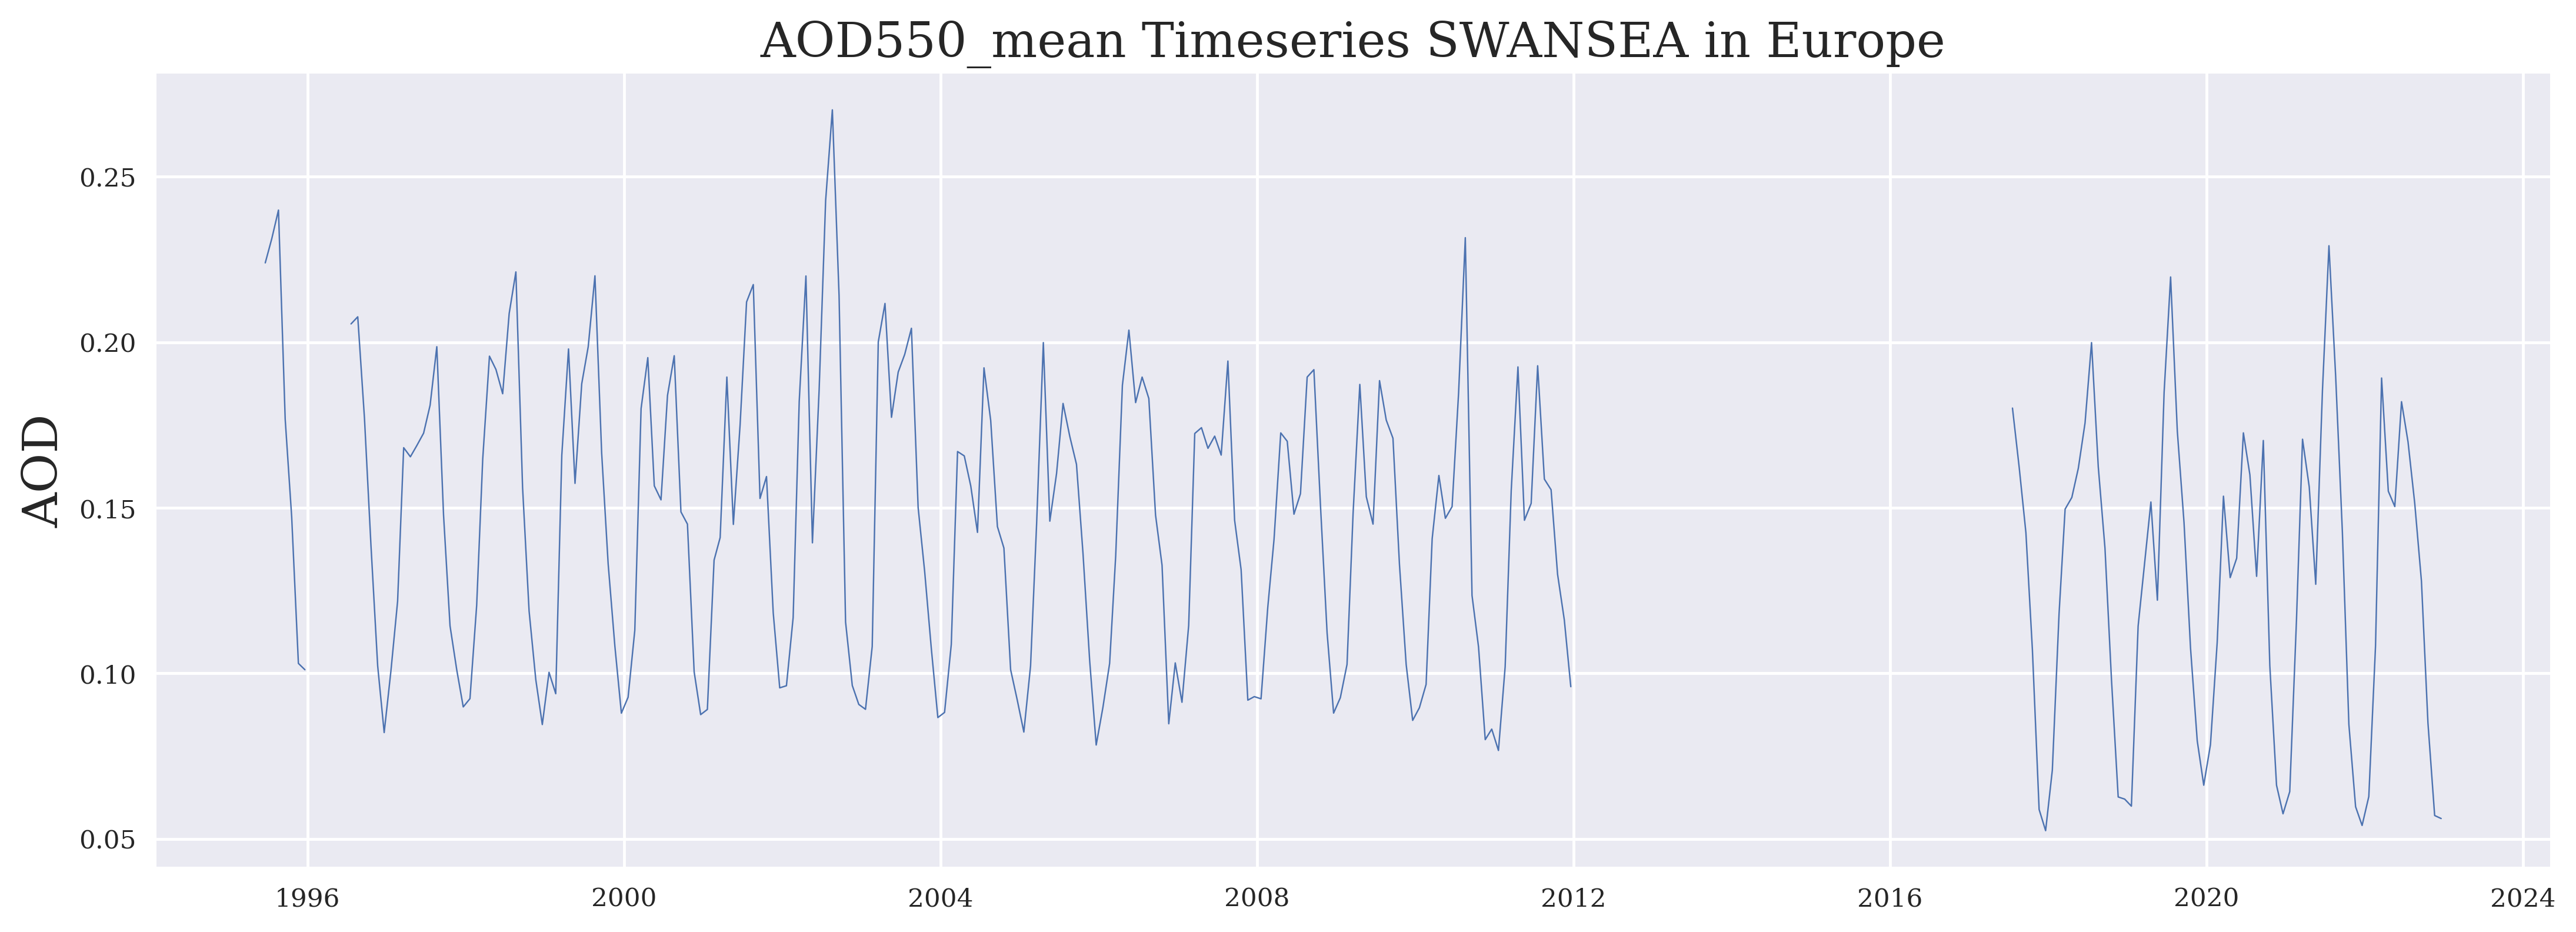

In [20]:
plt.plot_date(time, aod, '-', label = variable, linewidth = 0.5)
plt.ylabel("AOD")
plt.title(variable + ' Timeseries ' + algorithm + ' in ' + region)
plt.savefig(DATADIR + 'timeseries_' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')

**FIGURE 1:** This time series shows the long term behaviour of aerosol preoperties in the selected region.

## <a id='climatology'></a> Use case 2: calculate and plot a multi-annual mean ("climatology")

We calculate a multi-annual mean for each sensor in the time series, i.e. for ATSR-2 (1995-2002), AATSR (2003-2011) and SLSTR (2017-2022) and use each of them for the respective time series.

In [21]:
## Climatology     
aod_standard_deviation_ges = []
aod_climatology_ges = []
#ATSR2                              
aod_standard_deviation1 = []
aod_climatology1 = []                            
for month in months: 
    aodmonth1 = []
    aodvar1 = []
    for year in years_ATSR2[2:]:
        t = year + month
        for file in files:
            if t in file:
                data_set = nc.Dataset(dir + file,'r')
                data_sel = data_set[variable][lat1 : lat2 , lon1 : lon2]
                data_mean = np.ma.mean(data_sel)
                data_var = (data_mean**2)/len(years_ATSR2[2:])
                aodmonth1.append(data_mean)
                aodvar1.append(data_var)
    expectation = sum(aodmonth1)/len(years_ATSR2[2:])    
    standard_deviation = np.sqrt(sum(aodvar1)-expectation**2) 
    aod_climatology1.append(expectation)
    aod_standard_deviation1.append(standard_deviation)
    
for i in range(len(years_ATSR2)):
    aod_climatology_ges.extend(aod_climatology1) 
    aod_standard_deviation_ges.extend(aod_standard_deviation1)   

#AATSR                              
aod_standard_deviation1 = []
aod_climatology1 = []                            
for month in months: 
    aodmonth1 = []
    aodvar1 = []
    for year in years_AATSR:
        t = year + month
        for file in files:
            if t in file:
                data_set = nc.Dataset(dir + file,'r')
                data_sel = data_set[variable][lat1 : lat2 , lon1 : lon2]
                data_mean = np.ma.mean(data_sel)
                data_var = (data_mean**2)/len(years_AATSR)
                aodmonth1.append(data_mean)
                aodvar1.append(data_var)
    expectation = sum(aodmonth1)/len(years_AATSR)   
    standard_deviation = np.sqrt(sum(aodvar1)-expectation**2) 
    aod_climatology1.append(expectation)
    aod_standard_deviation1.append(standard_deviation)
    
for i in range(len(years_AATSR)):
    aod_climatology_ges.extend(aod_climatology1) 
    aod_standard_deviation_ges.extend(aod_standard_deviation1)   

#DATA GAP
nan_list = [np.nan for i in range(12)]
aod_climatology_ges.extend(nan_list) 
aod_standard_deviation_ges.extend(nan_list) 
#SLSTR                              
aod_standard_deviation1 = []
aod_climatology1 = []                            
for month in months: 
    aodmonth1 = []
    aodvar1 = []
    for year in years_SLSTR:
        t = year + month
        for file in files:
            if t in file:
                data_set = nc.Dataset(dir + file,'r')
                data_sel = data_set[variable][lat1 : lat2 , lon1 : lon2]
                data_mean = np.ma.mean(data_sel) - correct
                data_var = (data_mean**2)/len(years_SLSTR)
                aodmonth1.append(data_mean)
                aodvar1.append(data_var)
    expectation = sum(aodmonth1)/len(years_SLSTR)  
    standard_deviation = np.sqrt(sum(aodvar1)-expectation**2) 
    aod_climatology1.append(expectation)
    aod_standard_deviation1.append(standard_deviation)
    
for i in range(len(years_SLSTR)):
    aod_climatology_ges.extend(aod_climatology1) 
    aod_standard_deviation_ges.extend(aod_standard_deviation1)   

aod_standard_deviation1 = [aod_climatology_ges[i] + aod_standard_deviation_ges[i] for i in range(len(aod_standard_deviation_ges))] 
aod_standard_deviation2 = [aod_climatology_ges[i] - aod_standard_deviation_ges[i] for i in range(len(aod_standard_deviation_ges))] 

years_dual = years_ATSR2 + years_AATSR + ['2016'] + years_SLSTR
time_dual = []
for year in years_dual:
    for month in months:
        t_str = year + '-' + month
        time_dual.append(md.datestr2num(t_str))
    

Now we plot the time series with the climatologies.

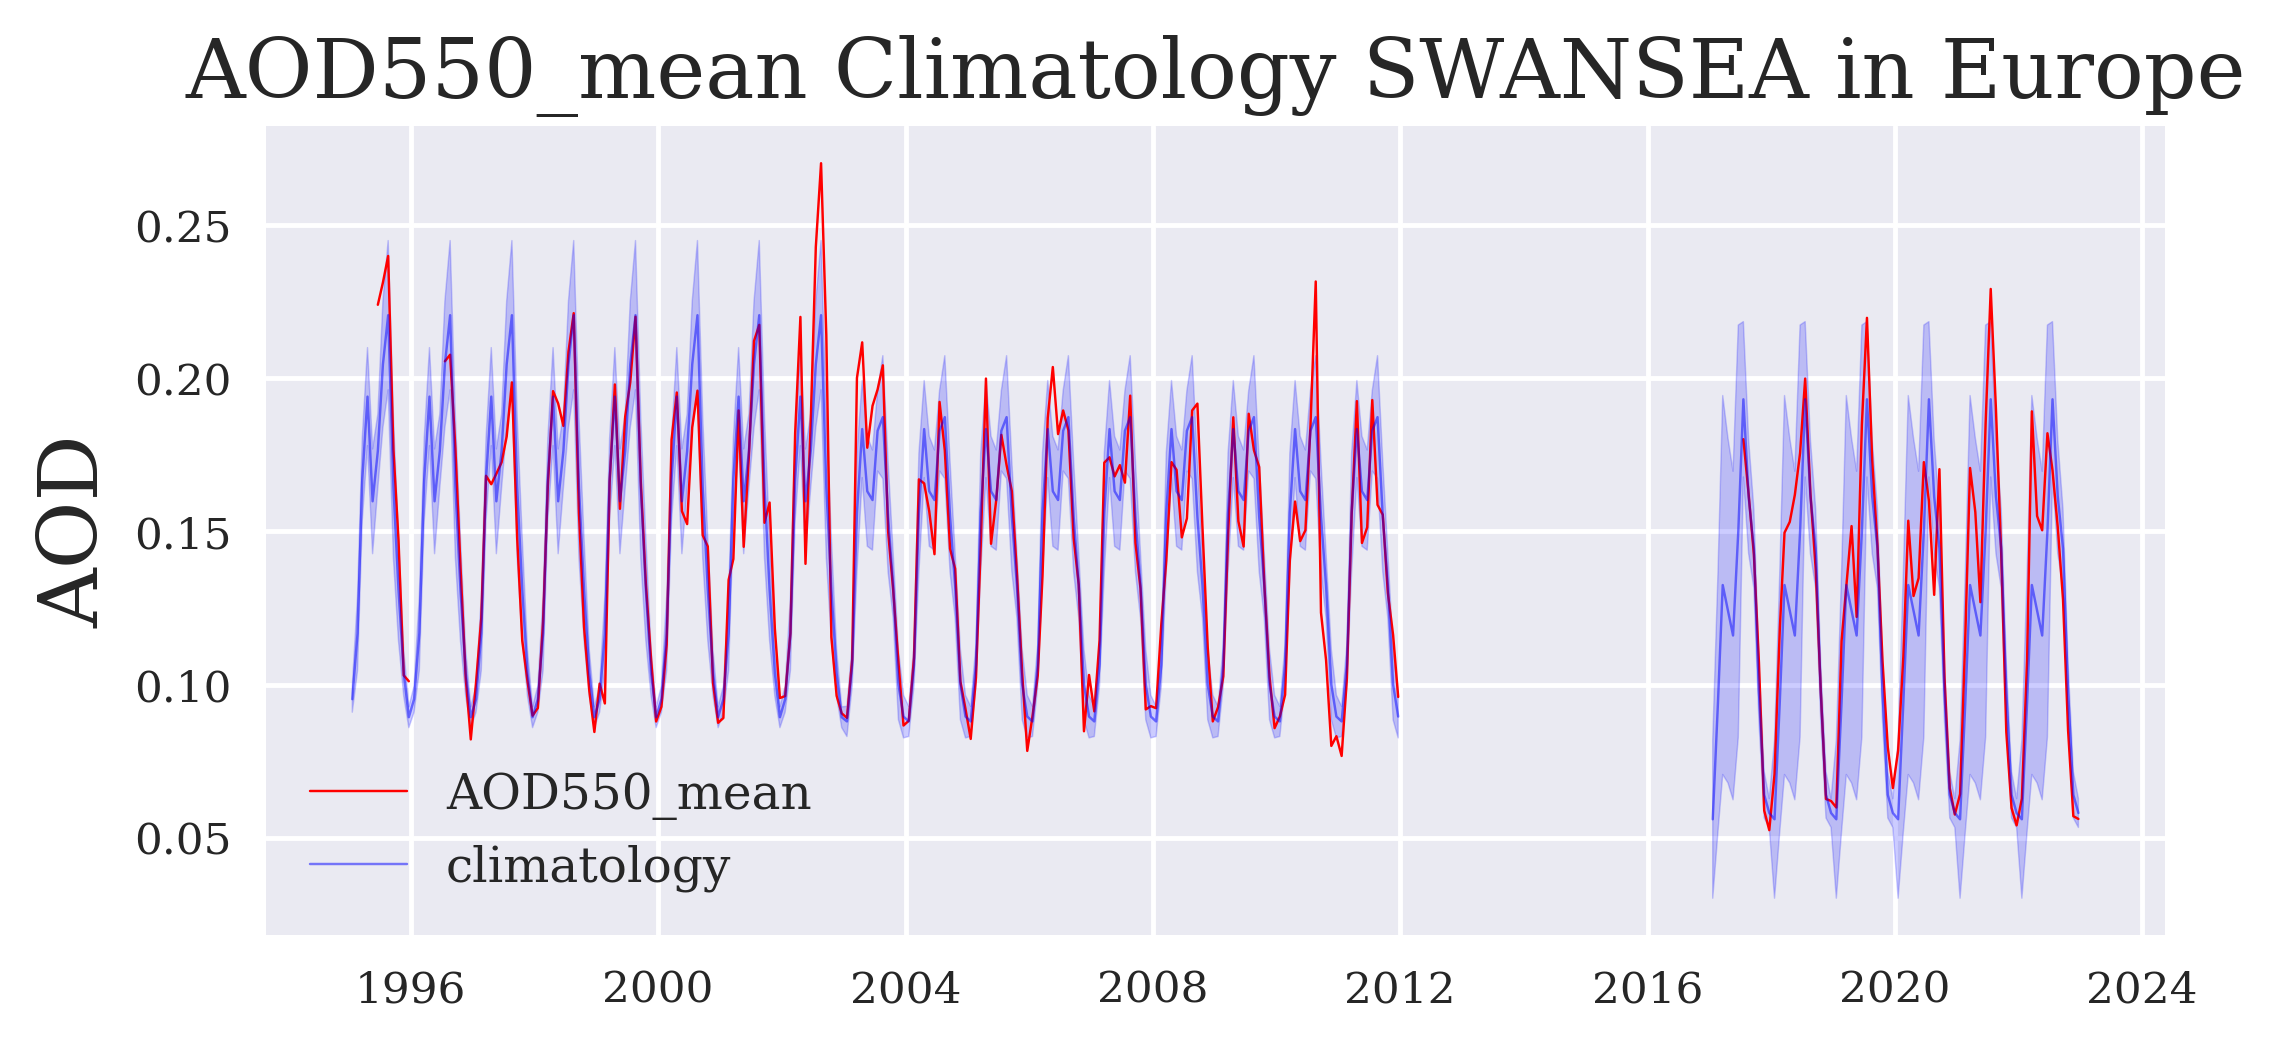

In [22]:
fig = plt.figure(figsize=(7,3))
plt.plot_date(time, aod, '-', label = variable, color = 'red', linewidth = 0.5)    
plt.fill_between(time_dual, aod_standard_deviation1, aod_standard_deviation2, color = 'blue', alpha = 0.2)
plt.plot(time_dual, aod_climatology_ges, '-', label = 'climatology', color = 'blue', linewidth = 0.5, alpha = 0.5)
plt.ylabel("AOD")
plt.legend()
plt.title(variable + ' Climatology ' + algorithm + ' in ' + region)
plt.savefig(DATADIR + 'timeseries_with_climatology_' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')


**FIGURE 2:** This time series overplotted to the repeated annual climatologies (per sensor) already indicates any episodic events outside the long-term variabiliy.

## <a id='anomaly'></a> Use case 3: Calculate and plot the anomaly timeseries

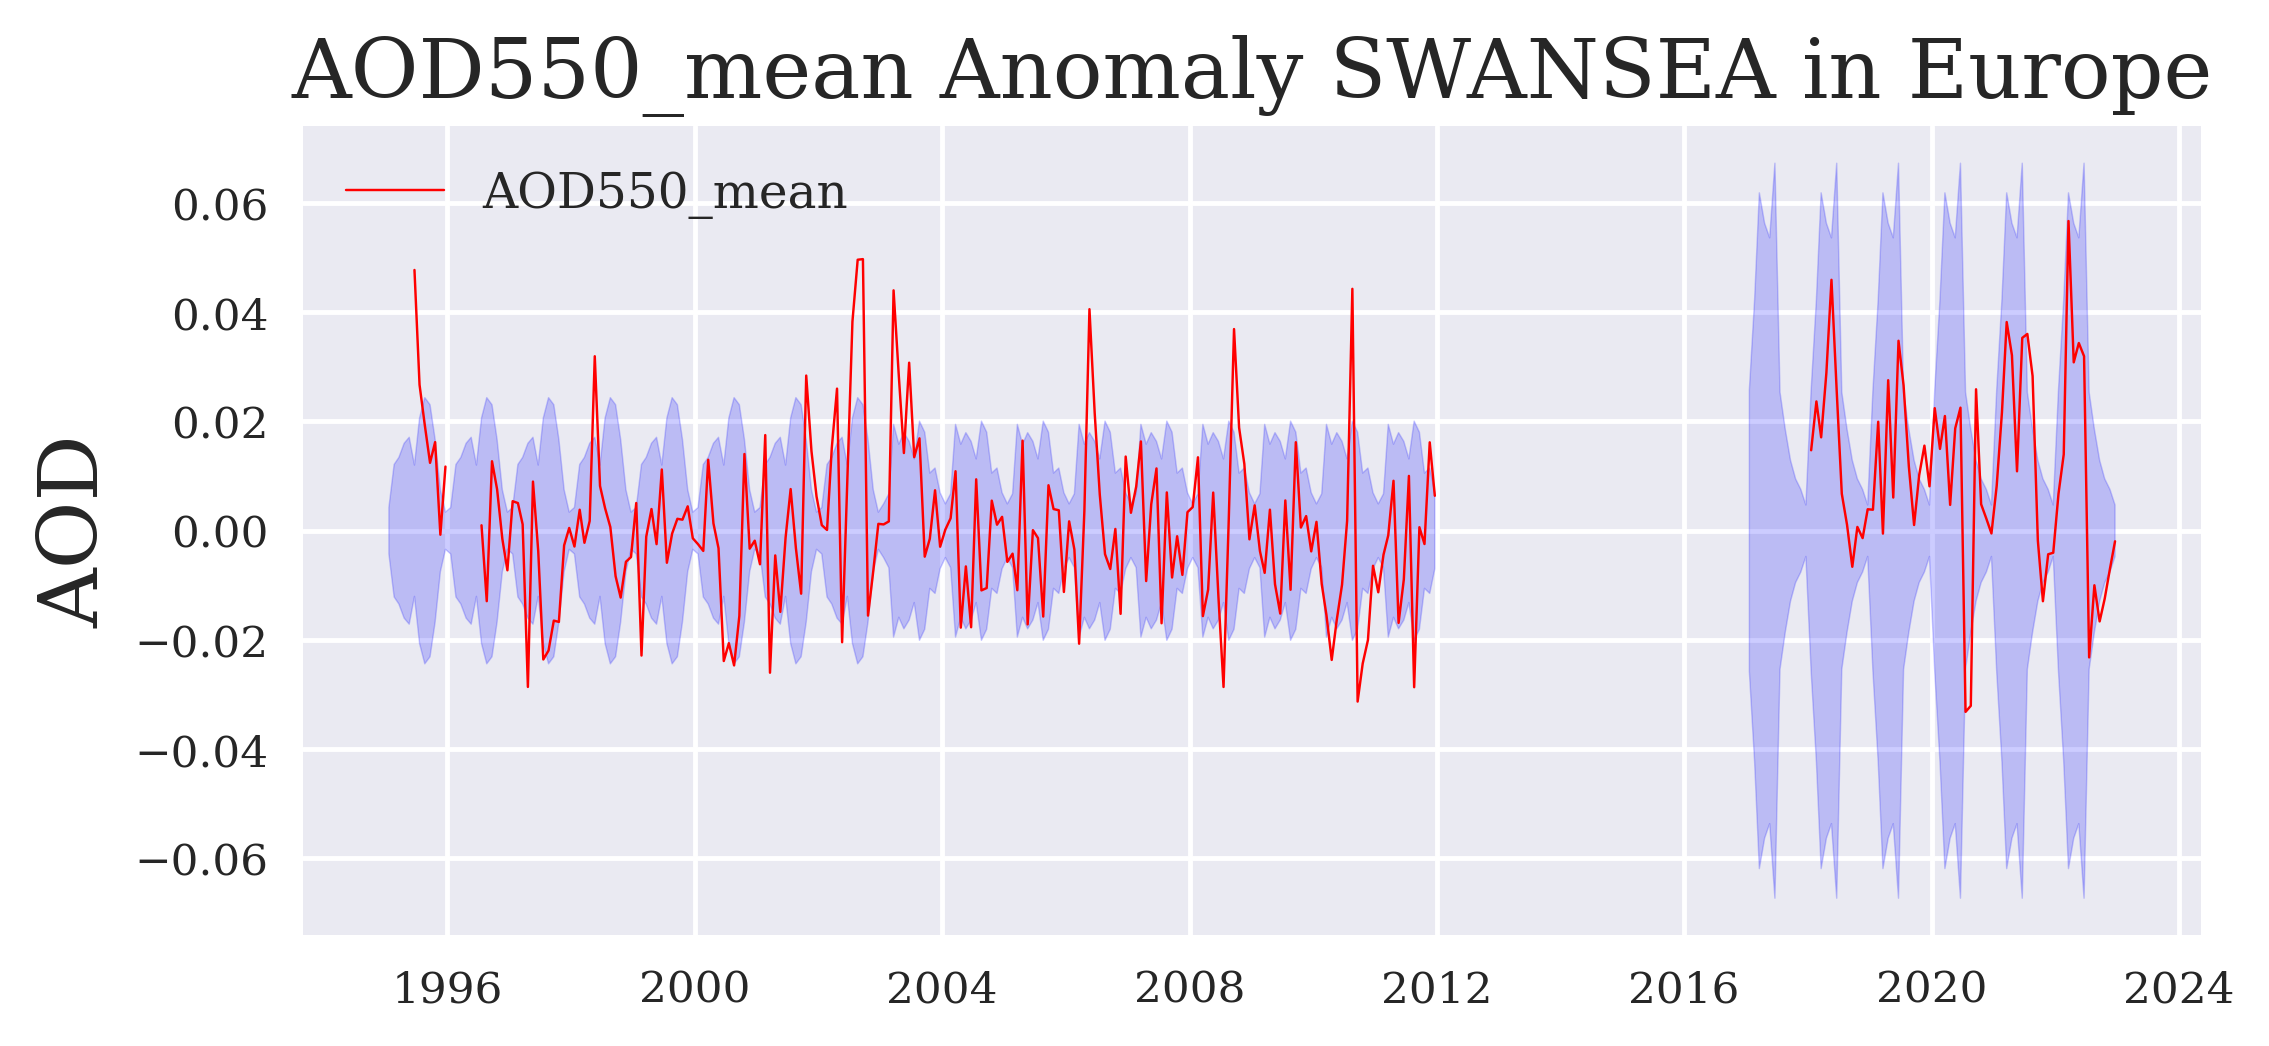

In [23]:
anomaly = [aod[i] - aod_climatology_ges[i] for i in range(len(aod))]
aod_standard_deviation_ges_ = [-aod_standard_deviation_ges[i] for i in range(len(aod_standard_deviation_ges))] 

fig = plt.figure(figsize=(7,3))
plt.plot_date(time, anomaly, '-', label = variable, color = 'red', linewidth = 0.5)    
plt.fill_between(time_dual, aod_standard_deviation_ges, aod_standard_deviation_ges_, color = 'blue', alpha = 0.2)
plt.ylabel("AOD")
plt.legend()
plt.title(variable + ' Anomaly ' + algorithm + ' in ' + region)
plt.savefig(DATADIR + 'anomaly_timeseries_' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')

**FIGURE 3:** This anomaly record shows more clearly those episodic extreme events as outliers outside the shaded long-term variability and possibly also any trend of the data record in this region (e.g. decreases in Europe or the U.S., increases in India or on Sout-Eact China increases before ~2008 and decreases since ~2012).

This closes our second Jupyter notebook on aerosol properties.

## Get more information about Earth Radiation Budget:

- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
- [About the Climate Data Store](https://cds.climate.copernicus.eu/)
- [About the Toolbox documentation](https://cds.climate.copernicus.eu/toolbox/doc/index.html)

## References

[Product User Guide for CDS Aerosol Properties](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/AER/C3S2_312a_Lot2_PUGS_AER_latest.pdf)

[Thomas Popp, Gerrit de Leeuw, Christine Bingen, Christoph Brühl, Virginie Capelle, Alain Chedin, 
Lieven Clarisse, Oleg Dubovik, Roy Grainger, Jan Griesfeller, Andreas Heckel, Stefan Kinne, Lars Klüser, 
Miriam Kosmale, Pekka Kolmonen, Luca Lelli, Pavel Litvinov, Linlu Mei, Peter North, Simon Pinnock, 
Adam Povey, Charles Robert, Michael Schulz, Larisa Sogacheva, Kerstin Stebel, Deborah Stein Zweers, 
Gareth Thomas, Lieuwe Gijsbert Tilstra, Sophie Vandenbussche, Pepijn Veefkind, Marco Vountas and 
Yong Xue, Development, Production and Evaluation of Aerosol Climate Data Records from European 
Satellite Observations (Aerosol_cci), Remote Sensing, 8, 421; doi:10.3390/rs8050421, 2016](https://www.mdpi.com/2072-4292/8/5/421)




